#Momento 1 - Res2NET + SSD - Deteccion de Objetos y Clasificacion
Ariel Rodrigo Colque Garcia

Dataset utilizado, imagenes marcados mas sus antaociones: [Images_Papel](https://drive.google.com/drive/folders/1LlezYz2M6APLOd4EdNUk_LfH5F6CGeW8?usp=drive_link)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preparar los datos

In [ ]:
# Ruta de las imágenes
PATH = '/content/drive/MyDrive/Data/2doParcial/Data'

# Cargar el archivo JSON desde una ruta específica
with open('/content/drive/MyDrive/Data/2doParcial/JSON/basura_labels.json') as f:
    json_data = json.load(f)

# Generar un índice aleatorio para seleccionar un elemento del archivo JSON
ix = random.randint(0, 15000)

# Obtener el elemento del archivo JSON correspondiente al índice aleatorio
json_data[ix]

{'annotation': {'filename': '20230518_090545.jpg',
  'size': {'width': '800', 'height': '600', 'depth': '3'},
  'object': [{'name': 'bolsa',
    'bndbox': {'top': 212.0,
     'left': 200.0,
     'height': 159.0,
     'width': 162.0}}]}}

In [ ]:
import random
import os
import numpy as np
import torch.nn as nn
import torchvision


def loadImages(json_data, PATH, split=0.1):
    img_train = []  # Lista para almacenar las rutas de las imágenes de entrenamiento
    labels_train = []  # Lista para almacenar las etiquetas de entrenamiento
    img_test = []  # Lista para almacenar las rutas de las imágenes de prueba
    labels_test = []  # Lista para almacenar las etiquetas de prueba
    
    num_examples = len(json_data)  # Obtener el número total de ejemplos en json_data
    num_test_examples = int(num_examples * split)  # Calcular el número de ejemplos para la prueba
    test_indices = random.sample(range(num_examples), num_test_examples)  # Obtener índices aleatorios para los ejemplos de prueba
    
    # Iterar sobre los ejemplos en json_data
    for i, example in enumerate(json_data):
        filename = example['annotation']['filename']  # Obtener el nombre de archivo del ejemplo
        
        # Verificar si existe el atributo 'object' en el ejemplo y si es una lista no vacía
        if 'object' in example['annotation'] and isinstance(example['annotation']['object'], list) and len(example['annotation']['object']) > 0:
            name_objects = example['annotation']['object'][0]['name']  # Obtener el nombre del objeto
            image_path = os.path.join(PATH, name_objects, filename)  # Construir la ruta de la imagen
            
            # Asignar el ejemplo a los conjuntos de entrenamiento o prueba según su índice
            if i not in test_indices:
                img_train.append(image_path)  # Agregar la ruta de la imagen a img_train
                labels_train.append(example)  # Agregar la etiqueta a labels_train
            else:
                img_test.append(image_path)  # Agregar la ruta de la imagen a img_test
                labels_test.append(example)  # Agregar la etiqueta a labels_test
    
    # Convertir las listas a arrays numpy y retornar los conjuntos de entrenamiento y prueba, junto con las etiquetas correspondientes
    return np.array(img_train), np.array(img_test), np.array(labels_train), np.array(labels_test)

In [ ]:
img_train, img_test, labels_train, labels_test = loadImages(json_data,PATH, split=0.2)
len(img_train), len(labels_train), len(img_test), len(labels_test)

(15890, 15890, 3972, 3972)

In [ ]:
img_train[2] , labels_train[2]

('/content/drive/MyDrive/Data/2doParcial/Data/bolsa/20230517_161204.jpg',
 {'annotation': {'filename': '20230517_161204.jpg',
   'size': {'width': '800', 'height': '600', 'depth': '3'},
   'object': [{'name': 'bolsa',
     'bndbox': {'top': 171.0,
      'left': 290.0,
      'height': 222.0,
      'width': 198.0}}]}})

In [ ]:
classes = [
    'fondo',
    'bolsa', 
    'papel', 
    'carton', 
    'plastoformo'
    ]
    
num_classes = 5

In [ ]:
import torch
from skimage import io
device = "cuda" if torch.cuda.is_available() else "cpu"
from skimage import color

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, trans, device):
        # Conjunto de datos de entrada (rutas de las imágenes)
        self.X = X
        # Conjunto de etiquetas correspondientes
        self.y = y
        # Transformación aplicada a las imágenes
        self.trans = trans
        # Dispositivo de cómputo (por ejemplo, CPU o GPU)
        self.device = device

    def __len__(self):
        # Devuelve la longitud del conjunto de datos
        return len(self.X)

    def __getitem__(self, ix):
        # Cargar la imagen utilizando la ruta del índice ix
        img = io.imread(self.X[ix])
        # Devolver la imagen normalizada y su etiqueta correspondiente
        return torch.from_numpy(img / 255.).float(), self.y[ix]
     

In [ ]:
import albumentations as A

# Crear una transformación que cambie el tamaño de las imágenes y las cajas a 70 x 70

trans = A.Compose([
    A.Resize(70, 70)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

datasetPrueba = {
    'train': Dataset(img_train, labels_train, trans, device), 
    'test': Dataset(img_test ,labels_test, trans, device)
}

len(datasetPrueba['train']), len(datasetPrueba['test'])


(15890, 3972)

In [ ]:
img, label = datasetPrueba['train'][0]

In [ ]:
img.shape

torch.Size([600, 800, 3])

In [ ]:
img, label

(tensor([[[0.3569, 0.3843, 0.4863],
          [0.3490, 0.3765, 0.4784],
          [0.3529, 0.3804, 0.4824],
          ...,
          [0.8431, 0.8745, 0.8314],
          [0.8275, 0.8588, 0.8157],
          [0.7686, 0.8000, 0.7569]],
 
         [[0.3451, 0.3725, 0.4745],
          [0.3412, 0.3686, 0.4706],
          [0.3451, 0.3725, 0.4745],
          ...,
          [0.8314, 0.8627, 0.8196],
          [0.7882, 0.8196, 0.7765],
          [0.7647, 0.7961, 0.7529]],
 
         [[0.3529, 0.3804, 0.4824],
          [0.3490, 0.3765, 0.4784],
          [0.3529, 0.3804, 0.4824],
          ...,
          [0.8000, 0.8314, 0.7882],
          [0.7373, 0.7686, 0.7255],
          [0.7725, 0.8039, 0.7608]],
 
         ...,
 
         [[0.3137, 0.3020, 0.3451],
          [0.3137, 0.3020, 0.3451],
          [0.3137, 0.3020, 0.3451],
          ...,
          [0.7059, 0.6863, 0.6706],
          [0.6510, 0.6314, 0.6157],
          [0.5922, 0.5725, 0.5569]],
 
         [[0.3098, 0.2980, 0.3412],
          [0

# Visualizacion del Dataset

In [ ]:
def convert_to_xmin_xmax_ymin_ymax(top, left, height, width):
    # Calcular las coordenadas del borde izquierdo y derecho de la caja delimitadora
    xmin = left
    xmax = left + width
    # Calcular las coordenadas del borde superior e inferior de la caja delimitadora
    ymin = top
    ymax = top + height
    # Devolver las coordenadas de la caja delimitadora en el formato xmin, xmax, ymin, ymax
    return xmin, xmax, ymin, ymax

In [ ]:
def get_sample(ix):
    # Obtener la imagen y la etiqueta correspondiente del dataset de prueba
    img_np, label = datasetPrueba['train'][ix]
    
    # Obtener las anotaciones de la imagen
    anns = label['annotation']['object']
    
    # Verificar si las anotaciones son una lista
    if type(anns) is not list:
        anns = [anns]
    
    # Obtener los índices de las clases correspondientes a las anotaciones
    labels = np.array([classes.index(ann['name']) for ann in anns])
    
    # Crear una lista para almacenar las cajas delimitadoras
    bbs = []
    
    # Recorrer cada anotación y convertir las coordenadas a xmin, ymin, xmax, ymax
    for ann in anns:
        bb = ann['bndbox']
        xmin, xmax, ymin, ymax = convert_to_xmin_xmax_ymin_ymax(int(bb['top']), int(bb['left']), int(bb['height']), int(bb['width']))
        bbs.append([xmin, ymin, xmax, ymax])
    
    # Convertir las listas de etiquetas y cajas delimitadoras en arrays numpy
    bbs = np.array(bbs)
    anns = (labels, bbs)
    
    # Retornar la imagen y las anotaciones
    return img_np, anns


In [ ]:
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects

def plot_anns(img, anns, ax=None, bg=-1):
    # Verificar si se proporciona un objeto de ejes, de lo contrario, crear una nueva figura y ejes
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Mostrar la imagen en los ejes
    ax.imshow(img)
    
    # Obtener las etiquetas y las cajas delimitadoras del parámetro de anotaciones
    labels, bbs = anns
    
    # Recorrer cada etiqueta y caja delimitadora
    for lab, bb in zip(labels, bbs):
        # Verificar si se debe omitir un fondo específico o si la etiqueta no coincide con el fondo proporcionado
        if bg == -1 or lab != bg:
            # Obtener las coordenadas de la caja delimitadora
            x, y, xm, ym = bb
            w, h = xm - x, ym - y
            
            # Crear un objeto Rectangle para visualizar la caja delimitadora
            rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='blue', linewidth=3)
            
            # Crear un objeto Text para mostrar la etiqueta de la clase
            text = ax.text(x, y - 10, classes[lab], {'color': 'blue'})
            
            # Agregar un efecto de trazo al texto para resaltarlo
            text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
            
            # Agregar la caja delimitadora y el texto a los ejes
            ax.add_patch(rect)

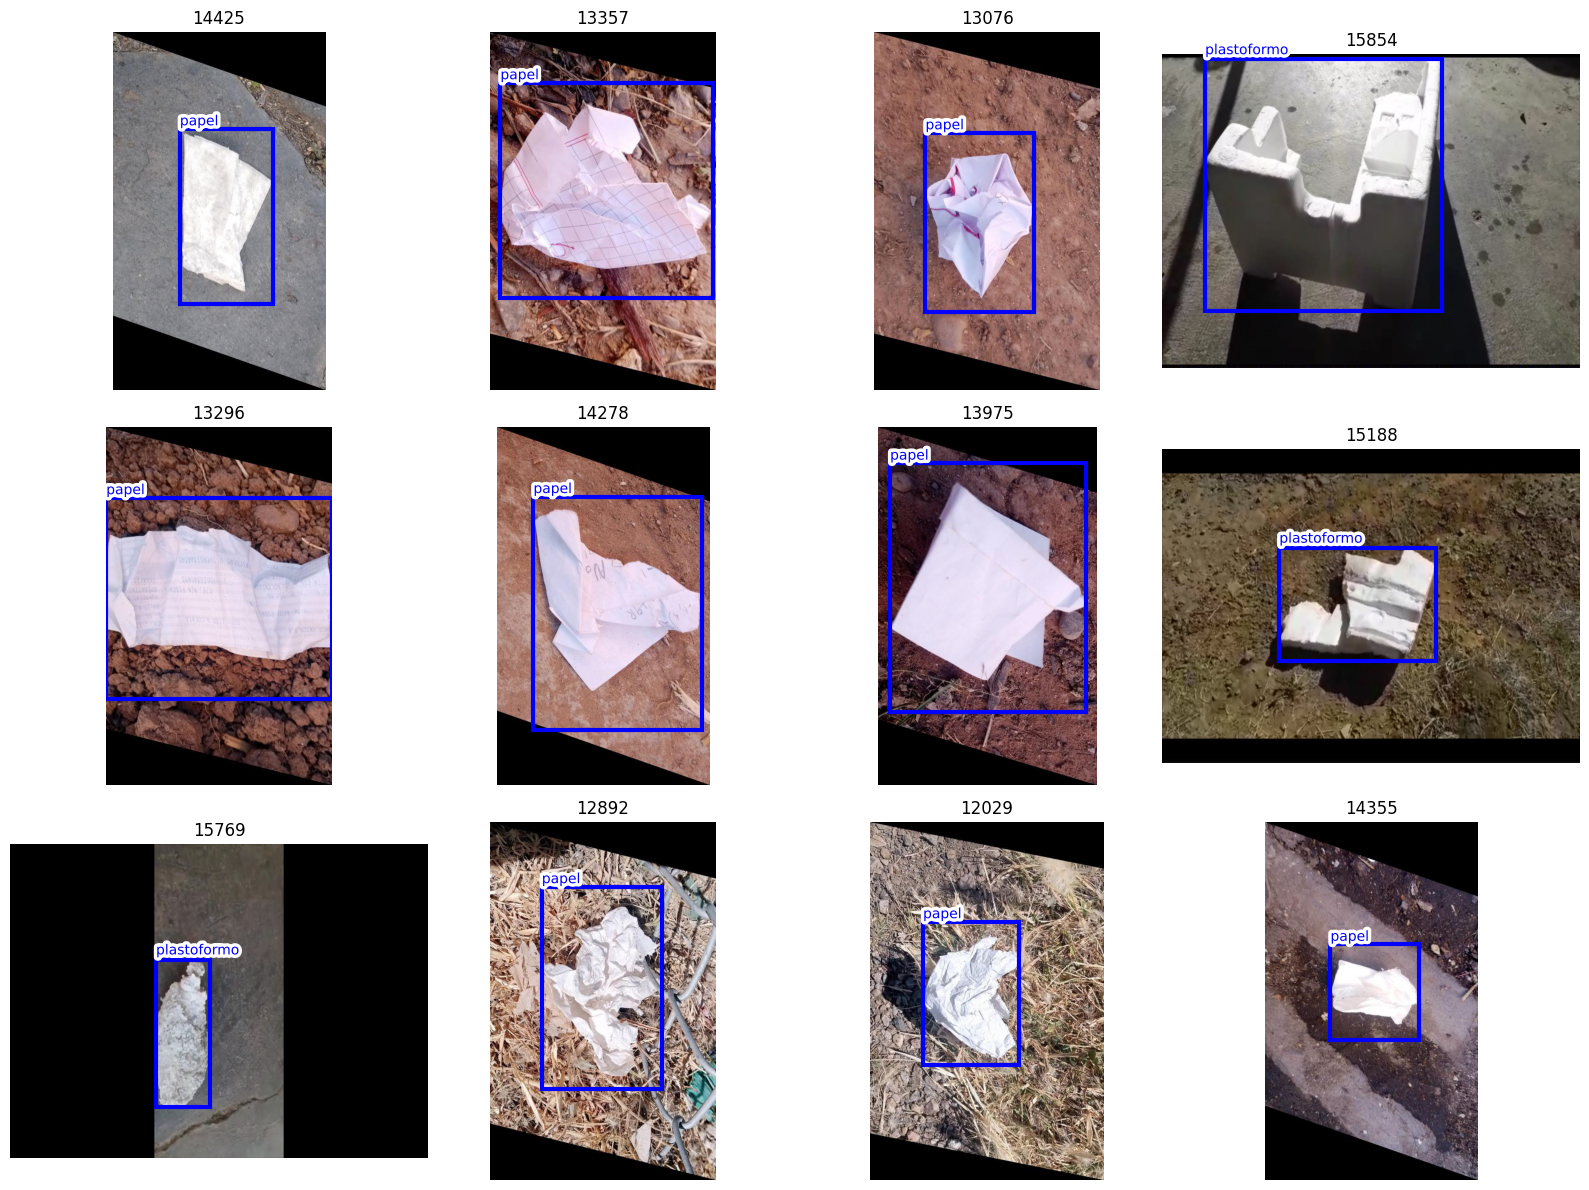

In [ ]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(datasetPrueba['train'])-1)
        ax.set_title(ix)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

#Propuesta de cajas

In [ ]:
def norm(bb, shape):
    # Normalizar la caja delimitadora bb en función de la forma de la imagen
    # shape = (alto, ancho)
    # bb = [x_min, y_min, x_max, y_max]
    
    # Obtener las dimensiones de la imagen
    h, w = shape
    
    # Calcular las coordenadas normalizadas de la caja delimitadora
    normalized_bb = np.array([bb[0] / w, bb[1] / h, bb[2] / w, bb[3] / h])
    
    # Retornar la caja delimitadora normalizada
    return normalized_bb


def unnorm(bb, shape):
    # Desnormalizar la caja delimitadora bb en función de la forma de la imagen
    # shape = (alto, ancho)
    # bb = [x_min, y_min, x_max, y_max]
    
    # Obtener las dimensiones de la imagen
    h, w = shape
    
    # Calcular las coordenadas desnormalizadas de la caja delimitadora
    unnorm_bb = np.array([bb[0] * w, bb[1] * h, bb[2] * w, bb[3] * h])
    
    # Retornar la caja delimitadora desnormalizada
    return unnorm_bb


def xyxy2xywh(bb):
    # Convertir las coordenadas de una caja delimitadora en formato (x_min, y_min, x_max, y_max)
    # a formato (x, y, width, height)
    
    # Utilizar la función torch.stack para apilar las coordenadas x, y, width y height en un tensor
    converted_bb = torch.stack([bb[:, 0], bb[:, 1], bb[:, 2] - bb[:, 0], bb[:, 3] - bb[:, 1]], axis=1)
    
    # Retornar el tensor de cajas delimitadoras convertidas
    return converted_bb


#def xywh2xyxy(bb):
#  return torch.stack([bb[:,0], bb[:,1], bb[:,0]+bb[:,2], bb[:,1]+bb[:,3]], axis=1)

In [ ]:
def plot_anchors(img, anns, anchors, ax=None, overlap=False):
    # Si no se proporciona un objeto de ejes (ax), se crea una nueva figura y ejes
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Mostrar la imagen en los ejes
    ax.imshow(img)
    
    # Obtener las etiquetas y cuadros delimitadores (bounding boxes)
    labels, bbs = anns
    
    # Convertir las coordenadas de los anclajes a formato (x, y, width, height)
    anchors = xyxy2xywh(anchors)
    
    # Desnormalizar los anclajes utilizando las dimensiones de la imagen
    _anchors = np.array([unnorm(a, img.shape[:2]) for a in anchors])
    
    # Dibujar los anclajes en los ejes
    for a in _anchors:
        x, y, w, h = a
        rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
    
    # Obtener las etiquetas y cuadros delimitadores nuevamente
    labels, bbs = anns
    
    # Iterar sobre las etiquetas y cuadros delimitadores
    for lab, bb in zip(labels, bbs):
        x, y, xm, ym = bb
        w, h = xm - x, ym - y
        
        # Dibujar el cuadro delimitador en los ejes
        rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='blue', linewidth=3)
        
        # Agregar el texto de la etiqueta encima del cuadro delimitador
        text = ax.text(x, y - 10, classes[lab], {'color': 'blue'})
        
        # Aplicar efectos visuales al texto para mayor legibilidad
        text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        
        # Agregar el cuadro delimitador y el texto a los ejes
        ax.add_patch(rect)

In [ ]:
def generate_anchors(scales, centers, sizes):
    # Inicializar listas para el recuento de anclajes, los anclajes y el tamaño de la cuadrícula
    k, anchors, grid_size = [], [], []
    
    # Iterar sobre las escalas
    for s in scales:
        cnt = 0  # Contador para el recuento de anclajes en cada escala
        
        # Iterar sobre los centros de anclaje
        for (x, y) in centers:
            # Iterar sobre los tamaños de anclaje
            for (w, h) in sizes:
                # Iterar sobre las posiciones dentro de cada ancla
                for i in range(s):
                    for j in range(s):
                        # Calcular las coordenadas del ancla y normalizarlas por la escala (s)
                        anchor = np.array([x+i-w/2, y+j-h/2, x+i+w/2, y+j+h/2]) / s
                        anchors.append(anchor)
                        
                        # Agregar el tamaño de la cuadrícula para el ancla actual
                        grid_size.append(np.array([1./s, 1./s]))
                        
                cnt = cnt + 1  # Incrementar el contador de anclajes
                
        k.append(cnt)  # Agregar el recuento de anclajes en la escala actual a la lista k
    
    # Convertir las listas de anclajes y tamaño de cuadrícula en tensores de tipo float
    return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()

(225, [3, 3, 3])

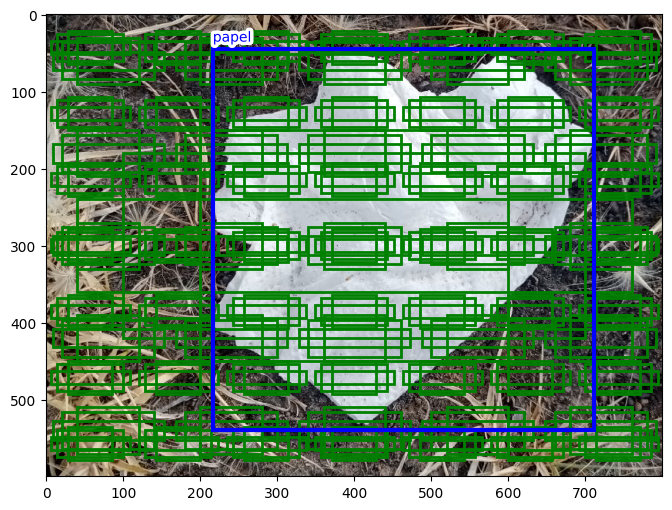

In [ ]:
import albumentations as A

# Generar un número entero aleatorio entre 0 y 1049
ix = random.randint(0, 1050 - 1)

# Obtener una muestra de imagen y anotaciones utilizando la función get_sample con el índice ix
img_np, anns = get_sample(ix)
# 29
# Separar las etiquetas y los cuadros delimitadores de las anotaciones
labels, bbs = anns

# Lista de escalas para generar los anclajes
scales = [7, 5, 1]              

# Lista de centros de anclaje
centers = [(0.5, 0.5)]

# Lista de escalas de tamaño
size_scales = [0.5]

# Lista de relaciones de aspecto
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]

# Lista de tamaños de anclaje calculados a partir de las escalas de tamaño y las relaciones de aspecto
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]

# Generar los anclajes utilizando la función generate_anchors
k, anchors, grid_size = generate_anchors(scales, centers, sizes)

# Graficar la imagen con las anotaciones y los anclajes generados
plot_anchors(img_np, anns, anchors)

# Imprimir la longitud de los anclajes y el recuento de anclajes por escala
len(anchors), k
# 225
# [3, 27, 3]
# k = lista que almacena el número de anclajes

In [ ]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    # Capa de convolución 2D
    # Parámetros:
    # c_in: número de canales de entrada
    # c_out: número de canales de salida
    # k: tamaño del kernel de convolución
    # padding: tamaño del relleno
    # stride: tamaño del paso
    return torch.nn.Sequential(
        # Capa de convolución
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),  
        # Función de activación ReLU
        torch.nn.ReLU(),  
        # Normalización por lotes, normaliza las activaciones de cada capa para que tengan una media y una varianza cercanas a cero
        torch.nn.BatchNorm2d(c_out),  
        # Agrupación máxima 2D, reducir el tamaño de los mapas de características y extraer las características más relevantes
        torch.nn.MaxPool2d(pk, stride=ps)  
    )


def flatten_conv(x, k):
    # Redimensionar el tensor de entrada
    # Parámetros:
    # x: tensor de entrada
    # k: factor de división de canales
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

    
class out_conv(torch.nn.Module):
    def __init__(self, c_in, k, n_classes):
        # Constructor de la clase
        # Parámetros:
        # c_in: número de canales de entrada
        # k: factor de división de canales
        # n_classes: número de clases
        super().__init__()
        self.k = k
        
        # Primera capa de convolución, localizacion
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)
        
        # Segunda capa de convolución, clasificacion
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)
        
    def forward(self, x):
        # Método de avance (forward)
        # Parámetros:
        # x: tensor de entrada
        return [
            # Resultado de la primera convolución aplanado
            flatten_conv(self.oconv1(x), self.k),
            # Resultado de la segunda convolución aplanado
            flatten_conv(self.oconv2(x), self.k)
        ]


def conv(c_i, c_o, stride=2, padding=1):
    # Capa de convolución
    # Parámetros:
    # c_i: número de canales de entrada
    # c_o: número de canales de salida
    # stride: tamaño del paso
    # padding: tamaño del relleno
    return nn.Sequential(
        # Capa de convolución 2D
        nn.Conv2d(c_i, c_o, 3, stride=stride, padding=padding),  
        # Función de activación ReLU
        nn.ReLU(),
        # Capa de normalización por lotes
        # nn.BatchNorm2d(c_o)
    )


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.4 MB/s eta 0:00:00


#Res2Net50_26w_4s
Res2Net50_26w_4s es un modelo de clasificación de imágenes basado en la arquitectura Res2Net. Res2Net es una variante de ResNet que introduce conexiones residuales jerárquicas dentro de un bloque residual. Esto permite representar características multi-escala a un nivel granular y aumentar el rango de campos receptivos para cada capa de la red.

El nombre Res2Net50_26w_4s indica que el modelo usa 50 capas de Res2Net, con un ancho de 26 y una escala de 4. El ancho se refiere al número de subconjuntos en los que se divide el canal de entrada dentro de cada bloque Res2Net. La escala se refiere al número de convoluciones consecutivas que se aplican a cada subconjunto.

El modelo Res2Net50_26w_4s tiene 25.7 millones de parámetros y 4.2 GMACs. Alcanza un error top-1 del 22.01% y un error top-5 del 6.15% en el conjunto de datos ImageNet-1k2. También se puede usar como una columna vertebral para otras tareas de visión computacional, como detección de objetos o segmentación semántica.

In [ ]:
import timm

res2NET = timm.create_model('res2net50_26w_4s', pretrained=True, num_classes=5)
res2NET.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottle2neck(
      (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bns): ModuleList(
        (0-2): 3 x BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pool): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (conv3): Conv2d(104, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
import timm
import torch.nn as nn

class SSDRes2NET(torch.nn.Module):
    def __init__(self, n_channels=3, n_classes=5, k=[1, 1, 1]):
        super().__init__()

        # Backbone Res2Net50
        self.res2net50 = timm.create_model('res2net50_26w_4s', pretrained=True, num_classes=5)  # Indicar que el número de clases es 5
        
        # Capas convolucionales adicionales
        self.conv3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),  # Capa de convolución 2D: entrada de 512 canales, salida de 256 canales, kernel de tamaño 1
            nn.ReLU(inplace=True),  # Función de activación ReLU
            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1),  # Capa de convolución 2D: entrada de 256 canales, salida de 128 canales, kernel de tamaño 3, paso de tamaño 2, relleno de tamaño 1
            nn.ReLU(inplace=True),  # Función de activación ReLU
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),  # Capa de convolución 2D: entrada de 128 canales, salida de 64 canales, kernel de tamaño 3, paso de tamaño 2, relleno de tamaño 1
            nn.ReLU(inplace=True),  # Función de activación ReLU
        )

        self.k = k
        
        # Cabezas (Heads)
        self.out4 = out_conv(64, self.k[0], n_classes)  # Cabeza de salida 4: entrada de 64 canales, k[0] canales de salida, n_classes clases
        self.out5 = out_conv(64, self.k[1], n_classes)  # Cabeza de salida 5: entrada de 64 canales, k[1] canales de salida, n_classes clases
        self.out6 = out_conv(64, self.k[2], n_classes)  # Cabeza de salida 6: entrada de 64 canales, k[2] canales de salida, n_classes clases

    def forward(self, x):
        # Backbone
        print(x.shape, 'Entrada')
        x = self.res2net50.conv1(x)
        print(x.shape, 'conv1')
        x = self.res2net50.layer1(x)
        print(x.shape, 'layer1')
        x = self.res2net50.layer2(x) 
        print(x.shape, 'layer2')

        # Capas convolucionales adicionales
        x1 = self.conv3(x) 
        print(x1.shape, 'x1')

        # Cabezas (Heads)
        o1l, o1c = self.out4(x1)
        print(o1l.shape, o1c.shape)  # Tamaño de las salidas de la cabeza 1
        o2l, o2c = self.out5(x1)
        print(o2l.shape, o2c.shape)  # Tamaño de las salidas de la cabeza 2
        o3l, o3c = self.out6(x1)
        print(o3l.shape, o3c.shape)  # Tamaño de las salidas de la cabeza 3
        
        return torch.cat([o1l,o2l,o3l],dim=1), torch.cat([o1c,o2c,o3c],dim=1)


In [ ]:
# k = [3, 3, 3]
modelo = SSDRes2NET(n_classes=len(classes), k=k)

# Realizar una prueba del forward
input_tensor = torch.rand((1, 3, 70, 70))
output = modelo(input_tensor)
print('Localizacion: ' ,output[0].shape)
print('Clasificacion: ', output[1].shape)

torch.Size([1, 3, 70, 70]) Entrada
torch.Size([1, 64, 35, 35]) conv1
torch.Size([1, 256, 35, 35]) layer1
torch.Size([1, 512, 18, 18]) layer2
torch.Size([1, 64, 5, 5]) x1
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
Localizacion:  torch.Size([1, 225, 4])
Clasificacion:  torch.Size([1, 225, 5])


In [ ]:
# Convierte los valores de activación de la red a coordenadas de bounding boxes (cajas delimitadoras) que se usan para la detección de objetos.
def actn_to_bb(actn, anchors, grid_size):
    # Transformar los valores de activación a coordenadas de bounding boxes utilizando la función tangente hiperbólica
    actn_bbs = torch.tanh(actn)
    
    # Calcular las coordenadas de los puntos de los bounding boxes a partir de los valores de activación y las anclas
    actn_p1 = anchors[:, :2] + actn_bbs[:, :2] * grid_size * 0.5  # Punto superior izquierdo
    actn_p2 = anchors[:, 2:] + actn_bbs[:, 2:] * grid_size * 0.5  # Punto inferior derecho
    
    # Concatenar los puntos para formar las coordenadas de los bounding boxes completos
    return torch.cat([actn_p1, actn_p2], dim=1)

In [ ]:
# Asigna cada prior box (caja previa) a un ground truth box (caja verdadera) basándose en la superposición entre ellos
# prior box es un tipo de caja delimitadora que se usa para mejorar la precisión de la detección de objetos
def map_to_ground_truth(overlaps):
    # Encontrar el índice y el valor máximo de superposición para cada fila (prior boxes)
    prior_overlap, prior_idx = overlaps.max(1)
    
    # Encontrar el índice y el valor máximo de superposición para cada columna (ground truth boxes)
    gt_overlap, gt_idx = overlaps.max(0)
    
    # Asignar un valor alto (1.99) al índice de superposición correspondiente a cada prior box
    gt_overlap[prior_idx] = 1.99
    
    # Asignar el índice de prior box correspondiente a cada ground truth box
    for i, o in enumerate(prior_idx):
        gt_idx[o] = i
    
    return gt_overlap, gt_idx

# IoU
La métrica IoU (Intersection over Union) es una forma de medir cuánto se parecen dos cajas delimitadoras. Se calcula como el área de la intersección entre las dos cajas dividida por el área de la unión entre las dos cajas. El valor de IoU está entre 0 y 1, donde 0 significa que no hay superposición y 1 significa que las cajas son idénticas

In [ ]:
class SSDLoss(torch.nn.Module):
    def __init__(self, anchors, grid_size, threshold=0.4):
        super().__init__()

        # Función de pérdida para la regresión de las coordenadas de las cajas
        self.loc_loss = torch.nn.L1Loss()  
# L1, que es la suma de las diferencias absolutas entre los valores predichos y los verdaderos. 
# Esta pérdida es sensible a los errores grandes y penaliza proporcionalmente a la magnitud del error.

         # Función de pérdida para la clasificación 
        self.class_loss = torch.nn.CrossEntropyLoss()
# Es una medida de la divergencia entre las probabilidades predichas y las verdaderas. 
# Esta pérdida es adecuada para problemas de clasificación multiclase y penaliza más a las predicciones erróneas con baja confianza.

        # Anclas utilizadas en el cálculo de pérdida
        self.anchors = anchors.to(device)  
        # Tamaño de la cuadrícula utilizada en el cálculo de pérdida
        self.grid_size = grid_size.to(device)  
        # Umbral utilizado para determinar las detecciones positivas
        self.threshold = threshold  

    def forward(self, preds, target):
        pred_bbs, pred_cs = preds 
        tar_bbs, c_t = target  # B x O x 4, B x O
        
        # Inicializar las pérdidas de localización y clasificación
        loc_loss, clas_loss = 0, 0  
        
        for pred_bb, pred_c, tar_bb, tar_c in zip(pred_bbs, pred_cs, tar_bbs, c_t):
            # Por defecto todas las etiquetas son 'background'
            labels = torch.zeros(len(self.anchors)).long().to(device)  
            
            if tar_bb.shape[0] is not 0:  # Es posible que haya imágenes sin detecciones
                # Calculamos el IoU de las detecciones con las cajas
                overlaps = torchvision.ops.box_iou(tar_bb, self.anchors) 
                # Nos quedamos con aquellas que coincidan
                gt_overlap, gt_idx = map_to_ground_truth(overlaps)  
                
                # Filtramos las detecciones que superen el umbral
                pos = gt_overlap > self.threshold  
                
                # Índices de las detecciones positivas
                pos_idx = torch.nonzero(pos)[:, 0]  
                # Índices correspondientes en las etiquetas
                tar_idx = gt_idx[pos_idx]  
                
                # Convertimos las salidas de la red en coordenadas de cajas
                pred_bb = actn_to_bb(pred_bb, self.anchors, self.grid_size)  
                # Anclas correspondientes a las detecciones positivas
                _anchors = pred_bb[pos_idx]  
                # Cajas verdaderas correspondientes a las detecciones positivas
                tar_bb = tar_bb[tar_idx]  
                
                # Pérdida de regresión de coordenadas
                loc_loss += self.loc_loss(_anchors, tar_bb)  
                # Etiquetas asignadas a las detecciones positivas
                
                labels[pos_idx] = tar_c[tar_idx]  
                # Pérdida de clasificación
                clas_loss += self.class_loss(pred_c, labels)  
        
        return clas_loss + loc_loss  # Suma de las pérdidas de clasificación y localización

<>:26: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:26: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-19-6ef4708ac7d9>:26: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if tar_bb.shape[0] is not 0:  # Es posible que haya imágenes sin detecciones


In [ ]:
def fit(model, X, target, epochs=1, lr=0.0001):
    # Mover el modelo a la GPU si está disponible
    model.to(device)  

    # Optimizador Adam para actualizar los parámetros del modelo
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
    # Criterio de pérdida personalizado para el modelo
    criterion = SSDLoss(anchors, grid_size)  

    for epoch in range(1, epochs+1):
        # Establecer el modelo en modo de entrenamiento
        model.train()  

        # Listas para almacenar las pérdidas de localización y clasificación
        train_loss_loc, train_loss_cls = [], [] 

        # Reiniciar los gradientes acumulados en el optimizador
        optimizer.zero_grad()  

        # Propagar hacia adelante los datos de entrada a través del modelo
        outputs = model(X)  

        # Calcular la pérdida utilizando el criterio de pérdida personalizado
        loss = criterion(outputs, target)  

        # Propagar hacia atrás los gradientes para calcular los gradientes de los parámetros
        loss.backward()  

        # Actualizar los parámetros del modelo utilizando los gradientes calculados
        optimizer.step()  
        
        # Agregar la pérdida de localización a la lista de pérdidas de entrenamiento
        train_loss_loc.append(loss.item())  
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss_loc):.5f}")  # Imprimir información del entrenamiento


In [ ]:
def plot_predict(img, anns, ax=None, bg=-1):
  if not ax:
    fig, ax = plt.subplots(figsize=(6, 4))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, xm, ym = bb
      w, h = xm - x, ym - y
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='blue', linewidth=3)
      text = ax.text(x, y - 10, classes[lab], {'color': 'blue'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

# Prueba con una Imagen PAPEL

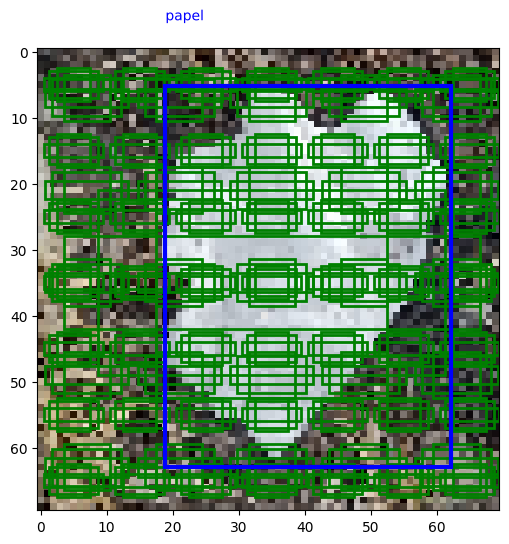

In [ ]:
import albumentations as A

# Definir la transformación
trans = A.Compose([
    A.Resize(70, 70)  # Redimensionar la imagen a 70x70 píxeles
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Obtener las etiquetas y las cajas del objeto
labels, bbs = anns

# Convertir la imagen a un arreglo numpy
img_np = np.array(img_np)

# Aplicar la transformación a la imagen, las cajas y las etiquetas
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

# Visualizar las anclas en la imagen
plot_anchors(img, (labels, bbs), anchors)

# Mostrar la imagen con las anclas
plt.show()

In [ ]:
# Convertir la imagen a un tensor de tipo FloatTensor y normalizar los valores en el rango [0, 1]
img_tensor = torch.FloatTensor(img / 255.).permute(2, 0, 1).unsqueeze(0).to(device)

# Normalizar las cajas delimitadoras en relación al tamaño de la imagen
bb_norm = [norm(bb, img.shape[:2]) for bb in bbs]

# Convertir las cajas delimitadoras normalizadas a un tensor de tipo FloatTensor y agregar una dimensión adicional
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0).to(device)

# Convertir las etiquetas a un tensor de tipo LongTensor y agregar una dimensión adicional
label_tensor = torch.tensor(labels).long().unsqueeze(0).to(device)

# Obtener las dimensiones de los tensores resultantes
img_tensor.shape, bb_tensor.shape, label_tensor.shape

(torch.Size([1, 3, 70, 70]), torch.Size([1, 1, 4]), torch.Size([1, 1]))

In [ ]:
model = SSDRes2NET(n_classes = len(classes), k=k)

fit(model, img_tensor, (bb_tensor, label_tensor), epochs=150)

torch.Size([1, 3, 70, 70]) Entrada
torch.Size([1, 64, 35, 35]) conv1
torch.Size([1, 256, 35, 35]) layer1
torch.Size([1, 512, 18, 18]) layer2
torch.Size([1, 64, 5, 5]) x1
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
Epoch 1/150 loss 1.76032
torch.Size([1, 3, 70, 70]) Entrada
torch.Size([1, 64, 35, 35]) conv1
torch.Size([1, 256, 35, 35]) layer1
torch.Size([1, 512, 18, 18]) layer2
torch.Size([1, 64, 5, 5]) x1
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
Epoch 2/150 loss 1.75310
torch.Size([1, 3, 70, 70]) Entrada
torch.Size([1, 64, 35, 35]) conv1
torch.Size([1, 256, 35, 35]) layer1
torch.Size([1, 512, 18, 18]) layer2
torch.Size([1, 64, 5, 5]) x1
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
Epoch 3/150 loss 1.74695
t

# Predicciones

In [ ]:
def predict(model, X):
    # Modo de evaluación del modelo
    model.eval()
    with torch.no_grad():
        # Mover los datos de entrada al dispositivo de ejecución
        X = X.to(device)
        
        # Obtener las predicciones del modelo
        bbs, labels = model(X)
        
        # Convertir las predicciones de las cajas a coordenadas de caja reales
        bbs = actn_to_bb(bbs[0].cpu(), anchors, grid_size)
    
    # Retornar las cajas y las etiquetas con la mayor confianza
    return bbs, torch.max(torch.softmax(labels.cpu(), axis=2)[0], axis=1)

In [ ]:
bbs, (scores, labels) = predict(model, img_tensor)
# bbs: Cajas predichas
# scores: Puntuaciones (confianza) asociadas a las cajas
# labels: Etiquetas asociadas a las cajas

bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
# Desnormalizar las coordenadas de las cajas utilizando la forma de la imagen original
# img.shape[:2]: Tamaño de la imagen original (alto y ancho)

torch.Size([1, 3, 70, 70]) Entrada
torch.Size([1, 64, 35, 35]) conv1
torch.Size([1, 256, 35, 35]) layer1
torch.Size([1, 512, 18, 18]) layer2
torch.Size([1, 64, 5, 5]) x1
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])


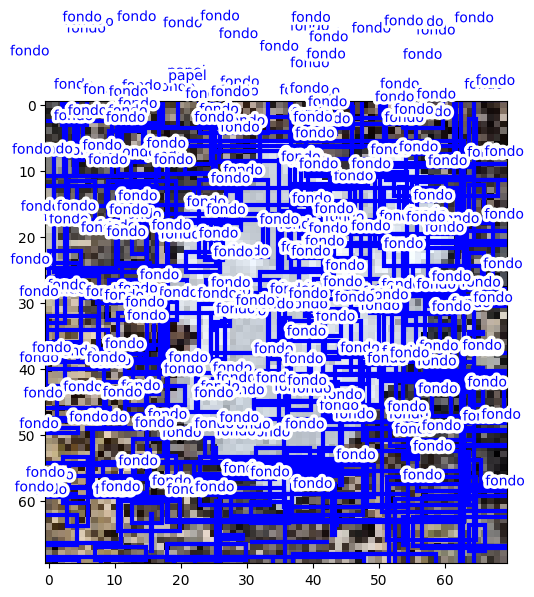

In [ ]:
plot_anns(img, (labels, bbs))
# Visualizar la imagen con las anotaciones de las cajas
# labels: Etiquetas asociadas a las cajas
# bbs: Cajas desnormalizadas

plt.show()
# Mostrar la imagen con las anotaciones

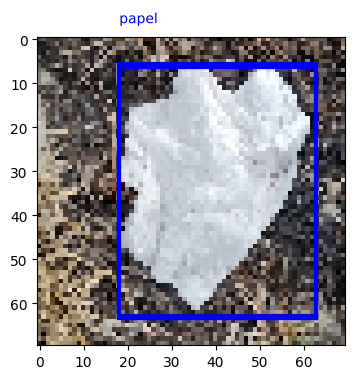

In [ ]:
import matplotlib.pyplot as plt


# Llamar a la función plot_anns para mostrar la imagen
plot_predict(img, (labels, bbs), bg=0)

# Mostrar la figura
plt.show()

In [ ]:
bbs, (scores, labels) = predict(model, img_tensor)
# Realizar la predicción utilizando el modelo
# model: Modelo utilizado para la predicción
# img_tensor: Tensor de la imagen de entrada

# Quitar las predicciones correspondientes a la clase de fondo (background)
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]
# Filtrar las cajas (bbs), etiquetas (labels) y puntajes (scores)
# Mantener solo las predicciones cuya etiqueta es mayor a 0 (clase distinta de background)

bbs, labels, scores
# Retornar las cajas filtradas, etiquetas y puntajes

torch.Size([1, 3, 70, 70]) Entrada
torch.Size([1, 64, 35, 35]) conv1
torch.Size([1, 256, 35, 35]) layer1
torch.Size([1, 512, 18, 18]) layer2
torch.Size([1, 64, 5, 5]) x1
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])
torch.Size([1, 75, 4]) torch.Size([1, 75, 5])


(tensor([[0.2566, 0.0797, 0.8990, 0.9045],
         [0.2588, 0.0896, 0.8992, 0.8991]]),
 tensor([2, 2]),
 tensor([0.7537, 0.6142]))

In [ ]:
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)
# Aplicar el algoritmo de supresión no máxima (NMS) para eliminar detecciones superpuestas
# bbs: Cajas de predicción
# scores: Puntajes de confianza asociados a las cajas
# iou_threshold: Umbral de IoU (Intersección sobre Unión) utilizado en el proceso de NMS

nms_ixs
# Retornar los índices de las cajas de predicción seleccionadas después de aplicar NMS

tensor([0])

<Figure size 400x200 with 0 Axes>

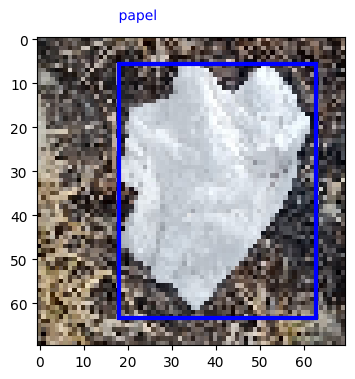

In [ ]:
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
# Seleccionar las cajas de predicción y las etiquetas correspondientes utilizando los índices obtenidos después de aplicar NMS

bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
# Desnormalizar las cajas de predicción para que coincidan con las dimensiones originales de la imagen

# Ajustar el tamaño de la figura
plt.figure(figsize=(4, 2))

# Llamar a la función plot_anns para mostrar la imagen con las predicciones
plot_predict(img, (labels, bbs), bg=0)

# Mostrar la figura
plt.show()


#2Da iamgen Bolsa

<ipython-input-16-76ac5efd2b0e>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()


(225, [3, 3, 3])

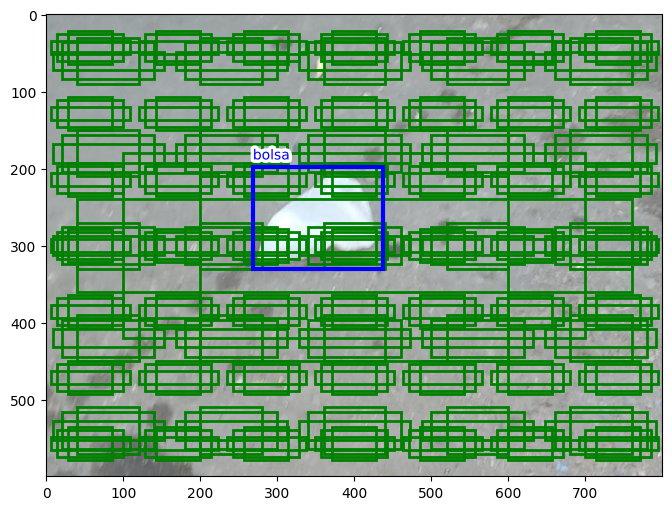

In [ ]:
import albumentations as A

# Obtener un índice aleatorio dentro del rango válido
ix = random.randint(0, 1050 - 1)

# Obtener una muestra de imagen y anotaciones
img_np, anns = get_sample(100)
labels, bbs = anns

# Definir los parámetros para generar las anclas
scales = [7, 5, 1]
centers = [(0.5, 0.5)]
size_scales = [0.5]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]

# Generar las anclas utilizando los parámetros definidos
k, anchors, grid_size = generate_anchors(scales, centers, sizes)

# Mostrar las anclas en la imagen
plot_anchors(img_np, anns, anchors)

# Obtener la longitud de las anclas generadas
num_anchors = len(anchors)
num_anchors, k


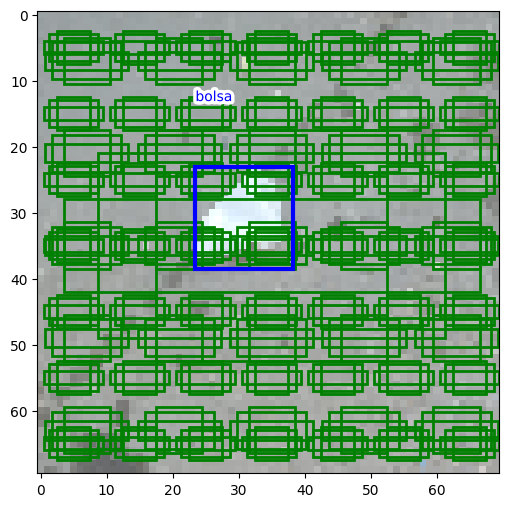

In [ ]:
trans = A.Compose([
    A.Resize(70, 70)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

labels, bbs = anns
img_np = np.array(img_np)
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

plot_anchors(img, (labels, bbs), anchors)
plt.show()

In [ ]:
# Convertir la imagen a un tensor y ajustar su tamaño y formato
img_tensor = torch.FloatTensor(img / 255.).permute(2, 0, 1).unsqueeze(0).to(device)

# Normalizar las coordenadas de las bounding boxes
bb_norm = [norm(bb, img.shape[:2]) for bb in bbs]

# Convertir las bounding boxes normalizadas a un tensor
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0).to(device)

# Convertir las etiquetas a un tensor de tipo long
label_tensor = torch.tensor(labels).long().unsqueeze(0).to(device)

# Obtener las dimensiones de los tensores resultantes
img_tensor.shape, bb_tensor.shape, label_tensor.shape


(torch.Size([1, 3, 70, 70]), torch.Size([1, 1, 4]), torch.Size([1, 1]))

In [ ]:
model = SSDRes2NET(n_classes = len(classes), k=k)

fit(model, img_tensor, (bb_tensor, label_tensor), epochs=150)

Epoch 1/150 loss 1.67890
Epoch 2/150 loss 1.67562
Epoch 3/150 loss 1.67212
Epoch 4/150 loss 1.66842
Epoch 5/150 loss 1.66401
Epoch 6/150 loss 1.65844
Epoch 7/150 loss 1.65144
Epoch 8/150 loss 1.64263
Epoch 9/150 loss 1.63211
Epoch 10/150 loss 1.61886
Epoch 11/150 loss 1.60228
Epoch 12/150 loss 1.58176
Epoch 13/150 loss 1.55647
Epoch 14/150 loss 1.52550
Epoch 15/150 loss 1.48781
Epoch 16/150 loss 1.44228
Epoch 17/150 loss 1.38766
Epoch 18/150 loss 1.32284
Epoch 19/150 loss 1.24673
Epoch 20/150 loss 1.15878
Epoch 21/150 loss 1.05898
Epoch 22/150 loss 0.94893
Epoch 23/150 loss 0.83083
Epoch 24/150 loss 0.70852
Epoch 25/150 loss 0.58798
Epoch 26/150 loss 0.47474
Epoch 27/150 loss 0.37231
Epoch 28/150 loss 0.28443
Epoch 29/150 loss 0.21258
Epoch 30/150 loss 0.15821
Epoch 31/150 loss 0.11899
Epoch 32/150 loss 0.09002
Epoch 33/150 loss 0.07176
Epoch 34/150 loss 0.05991
Epoch 35/150 loss 0.05104
Epoch 36/150 loss 0.04765
Epoch 37/150 loss 0.04672
Epoch 38/150 loss 0.04390
Epoch 39/150 loss 0.0

In [ ]:
# Obtener las bounding boxes y las puntuaciones y etiquetas predichas utilizando la función predict
bbs, (scores, labels) = predict(model, img_tensor)

# Desnormalizar las bounding boxes utilizando las dimensiones de la imagen original
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]


In [ ]:
# Obtener las bounding boxes y las puntuaciones y etiquetas predichas utilizando la función predict
bbs, (scores, labels) = predict(model, img_tensor)

# Filtrar las bounding boxes, etiquetas y puntuaciones para eliminar el fondo (background)
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]

# Imprimir las bounding boxes, etiquetas y puntuaciones resultantes
bbs, labels, scores


(tensor([[0.3500, 0.3500, 0.5450, 0.5664]]), tensor([1]), tensor([0.8287]))

In [ ]:
# Aplicar la supresión no máxima (NMS) a las bounding boxes y las puntuaciones
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)

# Imprimir los índices resultantes después de aplicar NMS
nms_ixs

tensor([0])

In [ ]:
# Filtrar las bounding boxes y las etiquetas utilizando los índices de NMS
bbs, labels = bbs[nms_ixs], labels[nms_ixs]

# Desnormalizar las bounding boxes
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]


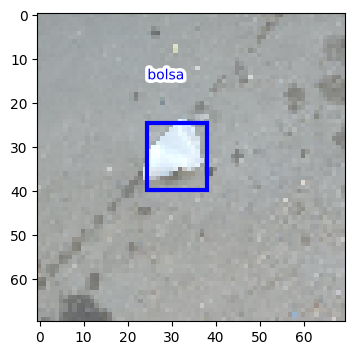

In [ ]:
plot_predict(img, (labels, bbs))
plt.show()

# Entrenamiento con Varias Imagenes

In [ ]:
with open('/content/drive/MyDrive/Data/2doParcial/JSON/papel.json') as f:
    json_data = json.load(f)
ix = random.randint(0,15000)
json_data[ix]

{'annotation': {'filename': 'R_KIMG_20230519_141317_522.jpg',
  'size': {'width': 600, 'height': 860, 'depth': '3'},
  'object': [{'name': 'papel',
    'bndbox': {'top': 237.0,
     'left': 145.0,
     'height': 352.0,
     'width': 273.0}}]}}

In [ ]:
classes = [
    'fondo',
    'bolsa', 
    'papel', 
    'carton', 
    'plastoformo'
    ]
    
num_classes = 5

In [ ]:
def loadImagesFromJson(json_data, PATH, split=0.1):
  # Inicializar listas vacías para almacenar las imágenes, las cajas delimitadoras y las etiquetas
  img_test = []
  img_train = []
  bndbox_test = []
  bndbox_train = []
  labels_test = []
  labels_train = []

  # Calcular el número de ejemplos y el número de ejemplos de prueba
  num_examples = len(json_data)
  num_test_examples = int(num_examples * split)

  # Generar índices aleatorios para los ejemplos de prueba
  test_indices = random.sample(range(num_examples), num_test_examples)

  # Iterar sobre los ejemplos del archivo json
  for i, example in enumerate(json_data):
      filename = example['annotation']['filename']
      
      # Verificar si la lista 'object' existe y no está vacía
      if 'object' in example['annotation'] and example['annotation']['object']:
          name = example['annotation']['object'][0]['name']
          # Iterar sobre las anotaciones de cada objeto en el ejemplo
          for annotation in example['annotation']['object']:
              bboxes = []
              label = annotation["name"]
              bbox = annotation["bndbox"]
              # Convertir las coordenadas de la caja delimitadora al formato (xmin, ymin, xmax, ymax)
              xmin, xmax, ymin, ymax = convert_to_xmin_xmax_ymin_ymax(int(bbox['top']), int(bbox['left']), int(bbox['height']), int(bbox['width']))
              # Convertir la etiqueta a entero usando el índice de la clase
              clase = classes.index(label)  
              bboxes = [xmin, ymin, xmax, ymax]
              # Construir la ruta de la imagen usando el nombre de la carpeta y el nombre del archivo
              image_path = os.path.join(PATH, name, filename)  
              
              # Asignar la imagen, la caja delimitadora y la etiqueta a las listas correspondientes según el índice del ejemplo
              if i in test_indices:
                  img_test.append(image_path)
                  bndbox_test.append(bboxes)
                  labels_test.append(clase)
              else:
                  img_train.append(image_path)
                  bndbox_train.append(bboxes)
                  labels_train.append(clase)

  # Convertir las listas a arrays de numpy y devolverlas
  return np.array(img_train), np.array(img_test), np.array(bndbox_train), np.array(bndbox_test), np.array(labels_train), np.array(labels_test)

In [ ]:
img_train, img_test, bndbox_train, bndbox_test, labels_train, labels_test = loadImagesFromJson(json_data, PATH, split=0.2)

In [ ]:
len(img_train), len(labels_train), len(bndbox_train)

(13743, 13743, 13743)

In [ ]:
ix = random.randint(0,15000)
img_train[ix],labels_train[ix], bndbox_train[ix]

('/content/drive/MyDrive/Data/2doParcial/Data/papel/LIMG_20230517_174200_694.jpg',
 2,
 array([  0,   0, 772, 600]))

In [ ]:
bndbox_train[600] , len(bndbox_train)

(array([367, 217, 426, 346]), 17279)

In [ ]:
from skimage import io
from torchvision import transforms
from PIL import Image
import numpy as np
import torch

# Definir una clase que hereda de torch.utils.data.Dataset
class Dataset(torch.utils.data.Dataset):
    # Definir el método constructor
    def __init__(self, X, label, bndbox, trans, device):
        # Asignar los atributos de la clase con los parámetros de entrada
        self.X = X # Lista de rutas de las imágenes
        self.label = label # Lista de etiquetas de las imágenes
        self.bndbox = bndbox # Lista de cajas delimitadoras de las imágenes
        self.trans = trans # Transformación de albumentations para aplicar a las imágenes
        self.device = device # Dispositivo donde se ejecutará el modelo (cpu o gpu)

    # Definir el método que devuelve la longitud del conjunto de datos
    def __len__(self):
        return len(self.X) # Devolver el número de elementos en la lista X

    # Definir el método que devuelve un elemento del conjunto de datos dado un índice
    def __getitem__(self, ix):
        img = io.imread(self.X[ix]) # Leer la imagen del archivo usando skimage.io.imread
        if len(img.shape) >= 3 and img.shape[2] == 4: # Si la imagen tiene cuatro canales (RGBA)
            img = color.rgba2rgb(img) # Convertir la imagen a tres canales (RGB) usando skimage.color.rgba2rgb
        elif len(img.shape) < 3: # Si la imagen tiene un solo canal (gris)
            img = color.gray2rgb(img) # Convertir la imagen a tres canales (RGB) usando skimage.color.gray2rgb
        if self.trans: # Si se ha definido una transformación
          img = self.trans(image=img)["image"] # Aplicar la transformación a la imagen usando albumentations
        img_tensor = torch.FloatTensor(img / 255.).permute(2, 0, 1) # Convertir la imagen a un tensor de PyTorch y normalizar los valores entre 0 y 1. Permutar los ejes para que el canal sea el primero
        
        bb_norm = norm(self.bndbox[ix], img.shape[:2]) # Normalizar las coordenadas de la caja delimitadora usando la función norm definida anteriormente. Usar el alto y el ancho de la imagen como referencia
        bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0) # Convertir la caja delimitadora a un tensor de PyTorch y añadir una dimensión extra al principio
        
        label_tensor =  torch.tensor(self.label[ix]).long().unsqueeze(0) # Convertir la etiqueta a un tensor de PyTorch y añadir una dimensión extra al principio
        
        return img_tensor, (bb_tensor, label_tensor) # Devolver una tupla con el tensor de la imagen y una tupla con el tensor de la caja delimitadora y el tensor de la etiqueta

In [ ]:
import albumentations as A
from skimage import color
#img_train, img_test, bndbox_train, bndbox_test, labels_train, labels_test
trans = A.Compose([
    A.Resize(70, 70)
])

dataset = {
    'train': Dataset(img_train, labels_train ,bndbox_train, trans, device), 
    'test': Dataset(img_test ,labels_test ,bndbox_test, trans, device)
}

len(dataset['train']), len(dataset['test'])

(13743, 3425)

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

In [ ]:
train_loader = dataloader['train']
first_batch = next(iter(train_loader))
print(first_batch)

[tensor([[[[0.3804, 0.3843, 0.4039,  ..., 0.1255, 0.2706, 0.1373],
          [0.4039, 0.3529, 0.3294,  ..., 0.1961, 0.2863, 0.1098],
          [0.3373, 0.3529, 0.2902,  ..., 0.4510, 0.3373, 0.1098],
          ...,
          [0.4980, 0.3961, 0.4118,  ..., 0.2510, 0.2235, 0.1608],
          [0.4235, 0.4314, 0.4196,  ..., 0.2510, 0.1843, 0.2118],
          [0.4078, 0.3882, 0.4235,  ..., 0.2431, 0.1961, 0.1961]],

         [[0.3098, 0.3137, 0.3333,  ..., 0.1216, 0.2902, 0.1373],
          [0.3333, 0.2824, 0.2627,  ..., 0.1961, 0.3216, 0.1098],
          [0.2667, 0.2824, 0.2392,  ..., 0.4667, 0.3804, 0.0941],
          ...,
          [0.5373, 0.4392, 0.4588,  ..., 0.2392, 0.2118, 0.1451],
          [0.4627, 0.4706, 0.4627,  ..., 0.2392, 0.1843, 0.2118],
          [0.4392, 0.4235, 0.4706,  ..., 0.2314, 0.1804, 0.1961]],

         [[0.2314, 0.2353, 0.2392,  ..., 0.1137, 0.2863, 0.1294],
          [0.2549, 0.2039, 0.1961,  ..., 0.1882, 0.3098, 0.0980],
          [0.1882, 0.1961, 0.1725,  ..., 

In [ ]:
# Definir una función que entrena un modelo usando un dataloader, un número de épocas y una tasa de aprendizaje
def fit(model, dataloader, epochs=1, lr=0.001):
    # Crear un optimizador Adam con los parámetros del modelo y la tasa de aprendizaje
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Crear un criterio de pérdida SSDLoss con los anclajes y el tamaño de la cuadrícula definidos anteriormente
    criterion = SSDLoss(anchors, grid_size)
    # Mover el modelo al dispositivo (cpu o gpu)
    model.to(device)
    # Inicializar un diccionario para almacenar el historial de pérdidas
    hist = {'loss': []}
    # Iterar sobre el número de épocas
    for epoch in range(1, epochs+1):
        # Crear una barra de progreso con tqdm para el dataloader de entrenamiento
        bar = tqdm(dataloader['train'])
        # Poner el modelo en modo de entrenamiento
        model.train()
        # Inicializar una lista vacía para almacenar las pérdidas de entrenamiento
        train_loss_loc = []
        # Iterar sobre las imágenes y los objetivos del dataloader de entrenamiento
        for images, targets in bar:
            # Mover las imágenes al dispositivo
            images = images.to(device)
            # Mover los objetivos al dispositivo
            targets = [target.to(device) for target in targets]
            # Poner a cero los gradientes del optimizador
            optimizer.zero_grad()
            # Pasar las imágenes por el modelo y obtener las salidas
            outputs = model(images)
            # Calcular la pérdida entre las salidas y los objetivos usando el criterio
            loss = criterion(outputs, targets)
            # Propagar la pérdida hacia atrás
            loss.backward()
            # Actualizar los parámetros del modelo con el optimizador
            optimizer.step()
            # Añadir la pérdida a la lista de pérdidas de entrenamiento
            train_loss_loc.append(loss.item())
        # Añadir la media de las pérdidas de entrenamiento al historial de pérdidas
        hist['loss'].append(np.mean(train_loss_loc))
        # Imprimir la época y la pérdida media de entrenamiento
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss_loc):.5f}")
    # Devolver el historial de pérdidas
    return hist

In [ ]:
model = SSDRes2NET(n_classes=len(classes), k=k)
fit(model,dataloader, epochs=25)

  0%|          | 1/430 [00:17<2:03:51, 17.32s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  0%|          | 2/430 [00:33<1:59:31, 16.76s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 4/430 [01:05<1:55:36, 16.28s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 5/430 [01:21<1:56:00, 16.38s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|▏         | 6/430 [01:38<1:56:00, 16.42s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 7/430 [01:55<1:56:36, 16.54s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 8/430 [02:12<1:58:08, 16.80s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 9/430 [02:30<2:00:12, 17.13s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 10/430 [02:47<1:59:50, 17.12s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 11/430 [03:03<1:57:38, 16.85s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 12/430 [03:19<1:56:08, 16.67s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 13/430 [03:36<1:56:35, 16.78s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 14/430 [03:54<1:58:24, 17.08s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 15/430 [04:12<1:59:29, 17.28s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▎         | 16/430 [04:29<1:57:50, 17.08s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 17/430 [04:46<1:57:30, 17.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 18/430 [05:01<1:53:20, 16.51s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 19/430 [05:17<1:52:06, 16.37s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▍         | 20/430 [05:32<1:50:10, 16.12s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▍         | 21/430 [05:49<1:49:57, 16.13s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▌         | 22/430 [06:05<1:50:00, 16.18s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▌         | 23/430 [06:19<1:46:19, 15.67s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 24/430 [06:34<1:44:20, 15.42s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 25/430 [06:51<1:46:34, 15.79s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 26/430 [07:07<1:46:31, 15.82s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▋         | 27/430 [07:24<1:48:34, 16.17s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 28/430 [07:39<1:46:56, 15.96s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 29/430 [07:56<1:49:20, 16.36s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 30/430 [08:11<1:46:14, 15.94s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 31/430 [08:28<1:46:25, 16.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 32/430 [08:43<1:44:16, 15.72s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 33/430 [09:00<1:47:08, 16.19s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 34/430 [09:17<1:48:01, 16.37s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 35/430 [09:35<1:51:15, 16.90s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 36/430 [09:51<1:50:10, 16.78s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▊         | 37/430 [10:09<1:52:01, 17.10s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 38/430 [10:26<1:50:42, 16.94s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 39/430 [10:42<1:49:45, 16.84s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 40/430 [10:58<1:46:57, 16.46s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|▉         | 41/430 [11:13<1:44:01, 16.05s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|▉         | 42/430 [11:31<1:47:47, 16.67s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 43/430 [11:49<1:49:45, 17.02s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 44/430 [12:05<1:46:47, 16.60s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 45/430 [12:20<1:44:25, 16.27s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 46/430 [12:35<1:41:37, 15.88s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 47/430 [12:52<1:42:54, 16.12s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 48/430 [13:08<1:42:09, 16.05s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█▏        | 49/430 [13:24<1:42:03, 16.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 50/430 [13:40<1:42:56, 16.25s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 51/430 [13:57<1:43:01, 16.31s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 52/430 [14:12<1:41:07, 16.05s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 53/430 [14:28<1:40:56, 16.06s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 55/430 [15:02<1:41:33, 16.25s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 56/430 [15:17<1:40:04, 16.06s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 57/430 [15:33<1:39:48, 16.05s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 58/430 [15:49<1:39:37, 16.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▎        | 59/430 [16:07<1:42:38, 16.60s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 60/430 [16:23<1:41:17, 16.43s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 62/430 [16:55<1:39:16, 16.19s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▍        | 63/430 [17:11<1:37:33, 15.95s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▍        | 64/430 [17:28<1:39:20, 16.29s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▌        | 65/430 [17:43<1:38:08, 16.13s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▌        | 66/430 [17:59<1:36:43, 15.94s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 67/430 [18:16<1:38:04, 16.21s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 68/430 [18:33<1:39:37, 16.51s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 69/430 [18:50<1:40:51, 16.76s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▋        | 70/430 [19:08<1:42:04, 17.01s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 71/430 [19:24<1:39:56, 16.70s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 72/430 [19:40<1:38:42, 16.54s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 73/430 [19:57<1:38:34, 16.57s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 75/430 [20:30<1:37:31, 16.48s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 76/430 [20:46<1:36:29, 16.35s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 77/430 [21:02<1:36:10, 16.35s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 78/430 [21:18<1:34:50, 16.17s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 79/430 [21:37<1:39:10, 16.95s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▊        | 80/430 [21:53<1:37:21, 16.69s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 81/430 [22:09<1:36:33, 16.60s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 82/430 [22:27<1:38:28, 16.98s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 83/430 [22:44<1:38:31, 17.04s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|█▉        | 84/430 [23:01<1:38:17, 17.05s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|█▉        | 85/430 [23:18<1:38:32, 17.14s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 86/430 [23:35<1:37:42, 17.04s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 87/430 [23:52<1:36:52, 16.95s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 88/430 [24:10<1:37:55, 17.18s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 89/430 [24:26<1:35:29, 16.80s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 90/430 [24:42<1:34:11, 16.62s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 91/430 [25:00<1:36:04, 17.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██▏       | 92/430 [25:17<1:35:29, 16.95s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 93/430 [25:34<1:35:19, 16.97s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 94/430 [25:52<1:37:58, 17.50s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 95/430 [26:10<1:38:50, 17.70s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 96/430 [26:28<1:39:03, 17.79s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 97/430 [26:45<1:35:55, 17.28s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 98/430 [27:00<1:32:48, 16.77s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 99/430 [27:17<1:32:03, 16.69s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 100/430 [27:35<1:33:51, 17.06s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 101/430 [27:51<1:33:18, 17.02s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▎       | 102/430 [28:08<1:31:34, 16.75s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 103/430 [28:24<1:30:49, 16.67s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 104/430 [28:42<1:32:27, 17.02s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 105/430 [28:58<1:30:51, 16.78s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▍       | 107/430 [29:32<1:31:35, 17.01s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▌       | 108/430 [29:48<1:29:29, 16.67s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▌       | 109/430 [30:04<1:28:02, 16.46s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 110/430 [30:21<1:28:33, 16.60s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 111/430 [30:37<1:27:19, 16.43s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 112/430 [30:53<1:26:11, 16.26s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▋       | 113/430 [31:09<1:24:31, 16.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 114/430 [31:25<1:24:52, 16.12s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 115/430 [31:41<1:24:30, 16.10s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 117/430 [32:14<1:24:35, 16.22s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 118/430 [32:31<1:25:42, 16.48s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 119/430 [32:46<1:23:15, 16.06s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 120/430 [33:03<1:24:50, 16.42s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 121/430 [33:19<1:24:37, 16.43s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 122/430 [33:36<1:24:15, 16.41s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▊       | 123/430 [33:52<1:23:06, 16.24s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 124/430 [34:08<1:22:13, 16.12s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 125/430 [34:29<1:29:56, 17.69s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 126/430 [34:45<1:27:51, 17.34s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|██▉       | 127/430 [35:02<1:26:54, 17.21s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|██▉       | 128/430 [35:18<1:24:58, 16.88s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 129/430 [35:34<1:22:16, 16.40s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 130/430 [35:51<1:23:34, 16.71s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 131/430 [36:07<1:22:30, 16.56s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 132/430 [36:22<1:19:59, 16.11s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 133/430 [36:39<1:20:54, 16.34s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 134/430 [36:54<1:18:32, 15.92s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███▏      | 135/430 [37:12<1:20:25, 16.36s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 136/430 [37:27<1:18:48, 16.08s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 137/430 [37:44<1:19:39, 16.31s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 138/430 [37:59<1:18:02, 16.04s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 139/430 [38:15<1:17:02, 15.89s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 140/430 [38:30<1:16:16, 15.78s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 141/430 [38:46<1:15:47, 15.73s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 142/430 [39:02<1:15:26, 15.72s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 143/430 [39:17<1:14:48, 15.64s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 144/430 [39:33<1:14:24, 15.61s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▎      | 145/430 [39:49<1:15:12, 15.83s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 146/430 [40:05<1:15:40, 15.99s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 147/430 [40:21<1:15:02, 15.91s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 148/430 [40:37<1:14:48, 15.92s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▍      | 149/430 [40:53<1:15:08, 16.04s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▍      | 150/430 [41:09<1:13:51, 15.83s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▌      | 151/430 [41:25<1:14:30, 16.03s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▌      | 152/430 [41:42<1:14:44, 16.13s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 153/430 [41:57<1:13:25, 15.91s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 154/430 [42:13<1:12:40, 15.80s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 155/430 [42:29<1:13:18, 16.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▋      | 156/430 [42:43<1:09:58, 15.32s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 157/430 [42:58<1:09:36, 15.30s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 158/430 [43:14<1:10:54, 15.64s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 159/430 [43:30<1:11:10, 15.76s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 160/430 [43:46<1:10:12, 15.60s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 161/430 [44:01<1:09:53, 15.59s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 162/430 [44:17<1:09:33, 15.57s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 163/430 [44:33<1:09:37, 15.65s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 164/430 [44:50<1:11:45, 16.19s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 165/430 [45:05<1:10:11, 15.89s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▊      | 166/430 [45:21<1:10:24, 16.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▉      | 167/430 [45:37<1:09:39, 15.89s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▉      | 168/430 [45:54<1:10:26, 16.13s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▉      | 169/430 [46:09<1:08:52, 15.83s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|███▉      | 170/430 [46:25<1:08:33, 15.82s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|███▉      | 171/430 [46:40<1:07:39, 15.68s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|████      | 172/430 [46:56<1:07:37, 15.73s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|████      | 173/430 [47:10<1:05:25, 15.27s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|████      | 174/430 [47:25<1:04:53, 15.21s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████      | 175/430 [47:41<1:05:10, 15.34s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████      | 176/430 [47:57<1:05:39, 15.51s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████      | 177/430 [48:13<1:06:47, 15.84s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████▏     | 178/430 [48:29<1:06:31, 15.84s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 179/430 [48:44<1:05:09, 15.58s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 180/430 [49:00<1:04:59, 15.60s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 181/430 [49:15<1:03:42, 15.35s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 182/430 [49:31<1:04:30, 15.61s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 183/430 [49:47<1:04:34, 15.68s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 184/430 [50:03<1:05:27, 15.96s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 185/430 [50:20<1:05:38, 16.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 186/430 [50:37<1:06:38, 16.39s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 187/430 [50:52<1:04:33, 15.94s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▎     | 188/430 [51:07<1:03:35, 15.77s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▍     | 189/430 [51:23<1:04:13, 15.99s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▍     | 190/430 [51:39<1:03:24, 15.85s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▍     | 191/430 [51:56<1:04:37, 16.22s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▍     | 192/430 [52:13<1:04:47, 16.33s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▍     | 193/430 [52:28<1:03:33, 16.09s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▌     | 194/430 [52:45<1:03:34, 16.16s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▌     | 195/430 [53:01<1:03:24, 16.19s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▌     | 196/430 [53:15<1:00:45, 15.58s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▌     | 197/430 [53:30<59:48, 15.40s/it]  

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▌     | 198/430 [53:47<1:00:56, 15.76s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▋     | 199/430 [54:01<59:23, 15.43s/it]  

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 200/430 [54:16<58:19, 15.22s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 201/430 [54:31<58:25, 15.31s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 202/430 [54:46<57:30, 15.14s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 203/430 [55:03<58:48, 15.54s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 204/430 [55:19<59:03, 15.68s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 205/430 [55:34<58:55, 15.71s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 206/430 [55:50<58:54, 15.78s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 207/430 [56:06<58:33, 15.76s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 208/430 [56:22<57:56, 15.66s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▊     | 209/430 [56:37<57:24, 15.59s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▉     | 210/430 [56:53<57:26, 15.67s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▉     | 211/430 [57:09<57:23, 15.73s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▉     | 212/430 [57:24<56:35, 15.58s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|████▉     | 213/430 [57:39<55:52, 15.45s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|████▉     | 214/430 [57:55<56:26, 15.68s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|█████     | 215/430 [58:09<54:29, 15.21s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|█████     | 216/430 [58:24<53:38, 15.04s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|█████     | 217/430 [58:38<51:52, 14.61s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████     | 218/430 [58:52<51:51, 14.68s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████     | 219/430 [59:08<52:23, 14.90s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████     | 220/430 [59:23<52:36, 15.03s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████▏    | 221/430 [59:39<52:58, 15.21s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 222/430 [59:55<53:35, 15.46s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 223/430 [1:00:09<51:58, 15.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 224/430 [1:00:24<52:02, 15.16s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 225/430 [1:00:39<51:05, 14.95s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 226/430 [1:00:53<49:55, 14.68s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 227/430 [1:01:08<50:01, 14.79s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 228/430 [1:01:24<50:54, 15.12s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 229/430 [1:01:40<51:20, 15.33s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▎    | 231/430 [1:02:10<50:36, 15.26s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▍    | 232/430 [1:02:26<50:56, 15.44s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▍    | 233/430 [1:02:41<50:15, 15.31s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▍    | 234/430 [1:02:57<50:51, 15.57s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▍    | 235/430 [1:03:13<50:48, 15.63s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▍    | 236/430 [1:03:29<50:37, 15.66s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▌    | 237/430 [1:03:42<48:38, 15.12s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▌    | 238/430 [1:03:57<48:04, 15.02s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▌    | 239/430 [1:04:12<47:41, 14.98s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▌    | 240/430 [1:04:27<47:34, 15.02s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▌    | 241/430 [1:04:42<47:22, 15.04s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▋    | 242/430 [1:04:58<47:33, 15.18s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 243/430 [1:05:12<46:18, 14.86s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 244/430 [1:05:27<45:56, 14.82s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 245/430 [1:05:42<46:21, 15.04s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 246/430 [1:05:57<46:12, 15.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 247/430 [1:06:14<47:28, 15.56s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 248/430 [1:06:29<46:41, 15.39s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 249/430 [1:06:43<45:34, 15.11s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 250/430 [1:06:59<45:28, 15.16s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 251/430 [1:07:13<44:18, 14.85s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▊    | 252/430 [1:07:27<43:35, 14.69s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▉    | 253/430 [1:07:42<43:39, 14.80s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▉    | 254/430 [1:07:56<42:37, 14.53s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▉    | 255/430 [1:08:11<42:49, 14.68s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|█████▉    | 256/430 [1:08:27<43:13, 14.91s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|█████▉    | 257/430 [1:08:41<42:55, 14.89s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|██████    | 258/430 [1:08:56<42:28, 14.82s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|██████    | 259/430 [1:09:12<42:59, 15.08s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|██████    | 260/430 [1:09:27<42:39, 15.06s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████    | 261/430 [1:09:41<41:23, 14.70s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████    | 262/430 [1:09:56<41:19, 14.76s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████    | 263/430 [1:10:11<41:18, 14.84s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████▏   | 264/430 [1:10:25<41:03, 14.84s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 265/430 [1:10:41<41:15, 15.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 266/430 [1:10:56<40:55, 14.97s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 267/430 [1:11:11<40:48, 15.02s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 268/430 [1:11:26<40:53, 15.14s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 269/430 [1:11:41<40:22, 15.05s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 270/430 [1:11:56<40:04, 15.03s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 271/430 [1:12:11<39:21, 14.85s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 273/430 [1:12:41<39:16, 15.01s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▎   | 274/430 [1:12:56<38:56, 14.98s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▍   | 275/430 [1:13:12<39:42, 15.37s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▍   | 276/430 [1:13:27<38:44, 15.10s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▍   | 277/430 [1:13:42<38:40, 15.17s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▍   | 278/430 [1:13:57<38:37, 15.25s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▍   | 279/430 [1:14:13<38:30, 15.30s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▌   | 280/430 [1:14:27<37:27, 14.99s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▌   | 281/430 [1:14:42<36:53, 14.86s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▌   | 282/430 [1:14:57<36:59, 15.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▌   | 283/430 [1:15:11<36:14, 14.79s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▌   | 284/430 [1:15:27<36:54, 15.17s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▋   | 285/430 [1:15:42<36:14, 15.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 286/430 [1:15:56<35:46, 14.90s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 287/430 [1:16:11<35:11, 14.76s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 288/430 [1:16:26<35:29, 15.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 289/430 [1:16:42<35:18, 15.03s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 290/430 [1:16:55<34:13, 14.67s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 291/430 [1:17:11<34:19, 14.82s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 292/430 [1:17:26<34:34, 15.03s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 293/430 [1:17:41<34:31, 15.12s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 294/430 [1:17:57<34:23, 15.17s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▊   | 295/430 [1:18:12<34:17, 15.24s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▉   | 297/430 [1:18:43<33:46, 15.23s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▉   | 298/430 [1:18:56<32:15, 14.66s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|██████▉   | 299/430 [1:19:10<31:47, 14.56s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|██████▉   | 300/430 [1:19:25<31:31, 14.55s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|███████   | 302/430 [1:19:56<31:57, 14.98s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|███████   | 303/430 [1:20:11<31:54, 15.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████   | 304/430 [1:20:25<31:22, 14.94s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████   | 305/430 [1:20:41<31:35, 15.16s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████   | 306/430 [1:20:57<31:39, 15.32s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████▏  | 307/430 [1:21:12<31:29, 15.36s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 309/430 [1:21:44<31:24, 15.58s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 310/430 [1:21:57<29:46, 14.89s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 311/430 [1:22:14<30:24, 15.33s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 312/430 [1:22:28<29:34, 15.04s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 313/430 [1:22:43<29:23, 15.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 314/430 [1:22:58<29:11, 15.10s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 315/430 [1:23:13<28:32, 14.89s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 316/430 [1:23:28<28:13, 14.85s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▎  | 317/430 [1:23:42<27:45, 14.74s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▍  | 318/430 [1:23:58<28:14, 15.13s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▍  | 319/430 [1:24:14<28:12, 15.25s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▍  | 320/430 [1:24:27<26:56, 14.69s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▍  | 321/430 [1:24:41<26:27, 14.57s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▍  | 322/430 [1:24:56<26:32, 14.75s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▌  | 323/430 [1:25:11<26:22, 14.79s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▌  | 324/430 [1:25:27<26:22, 14.93s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▌  | 325/430 [1:25:43<26:36, 15.21s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▌  | 326/430 [1:25:58<26:41, 15.40s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▌  | 327/430 [1:26:13<26:09, 15.24s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▋  | 328/430 [1:26:28<25:32, 15.02s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 330/430 [1:26:57<24:35, 14.76s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 331/430 [1:27:13<25:01, 15.17s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 332/430 [1:27:27<24:16, 14.86s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 333/430 [1:27:42<24:04, 14.89s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 334/430 [1:27:57<24:06, 15.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 335/430 [1:28:12<23:51, 15.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 336/430 [1:28:27<23:30, 15.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 337/430 [1:28:42<23:01, 14.85s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▊  | 338/430 [1:28:56<22:21, 14.58s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▉  | 339/430 [1:29:11<22:28, 14.82s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▉  | 340/430 [1:29:27<22:44, 15.16s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▉  | 341/430 [1:29:42<22:16, 15.02s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|███████▉  | 342/430 [1:29:56<21:33, 14.70s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|███████▉  | 343/430 [1:30:11<21:28, 14.81s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|████████  | 344/430 [1:30:25<21:06, 14.73s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|████████  | 345/430 [1:30:41<21:06, 14.90s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████  | 347/430 [1:31:09<20:12, 14.61s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████  | 348/430 [1:31:25<20:16, 14.83s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████  | 349/430 [1:31:39<19:59, 14.81s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 351/430 [1:32:09<19:23, 14.73s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 352/430 [1:32:24<19:20, 14.88s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 353/430 [1:32:40<19:20, 15.07s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 354/430 [1:32:55<18:56, 14.95s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 355/430 [1:33:09<18:21, 14.68s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 356/430 [1:33:24<18:18, 14.85s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 357/430 [1:33:39<18:14, 14.99s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 358/430 [1:33:53<17:31, 14.60s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 359/430 [1:34:08<17:32, 14.83s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▎ | 360/430 [1:34:23<17:18, 14.83s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▍ | 361/430 [1:34:37<16:42, 14.52s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▍ | 362/430 [1:34:51<16:26, 14.51s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▍ | 363/430 [1:35:07<16:33, 14.83s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▍ | 364/430 [1:35:22<16:17, 14.81s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▍ | 365/430 [1:35:37<16:11, 14.94s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▌ | 366/430 [1:35:51<15:35, 14.62s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▌ | 367/430 [1:36:06<15:32, 14.80s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▌ | 368/430 [1:36:21<15:13, 14.73s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▌ | 369/430 [1:36:35<14:57, 14.71s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▌ | 370/430 [1:36:50<14:48, 14.80s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▋ | 371/430 [1:37:06<14:53, 15.14s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 372/430 [1:37:21<14:28, 14.97s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 373/430 [1:37:36<14:22, 15.13s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 374/430 [1:37:52<14:10, 15.18s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 375/430 [1:38:06<13:49, 15.09s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 376/430 [1:38:22<13:35, 15.11s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 377/430 [1:38:38<13:36, 15.41s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 378/430 [1:38:52<13:07, 15.15s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 379/430 [1:39:08<13:00, 15.30s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 380/430 [1:39:23<12:39, 15.20s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▊ | 381/430 [1:39:39<12:31, 15.35s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▉ | 382/430 [1:39:53<11:58, 14.97s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▉ | 383/430 [1:40:08<11:44, 15.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▉ | 384/430 [1:40:24<11:42, 15.26s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|████████▉ | 385/430 [1:40:37<10:56, 14.59s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|████████▉ | 386/430 [1:40:53<11:00, 15.01s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|█████████ | 387/430 [1:41:09<10:58, 15.31s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|█████████ | 388/430 [1:41:24<10:38, 15.20s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|█████████ | 389/430 [1:41:39<10:20, 15.15s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████ | 390/430 [1:41:53<10:00, 15.01s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████ | 391/430 [1:42:09<09:52, 15.20s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████ | 392/430 [1:42:24<09:33, 15.09s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████▏| 393/430 [1:42:39<09:15, 15.02s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 394/430 [1:42:55<09:11, 15.33s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 395/430 [1:43:11<09:08, 15.66s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 396/430 [1:43:26<08:49, 15.58s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 397/430 [1:43:41<08:20, 15.18s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 398/430 [1:43:55<07:59, 14.99s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 399/430 [1:44:09<07:36, 14.73s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 400/430 [1:44:25<07:33, 15.11s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 401/430 [1:44:40<07:13, 14.96s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 402/430 [1:44:55<07:00, 15.00s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▎| 403/430 [1:45:10<06:44, 14.99s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▍| 404/430 [1:45:24<06:24, 14.77s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▍| 405/430 [1:45:39<06:10, 14.83s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▍| 406/430 [1:45:54<05:56, 14.87s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▍| 408/430 [1:46:24<05:26, 14.83s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▌| 409/430 [1:46:38<05:04, 14.52s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▌| 410/430 [1:46:52<04:47, 14.38s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▌| 411/430 [1:47:07<04:37, 14.62s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▌| 412/430 [1:47:20<04:16, 14.25s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▌| 413/430 [1:47:34<03:58, 14.04s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▋| 414/430 [1:47:49<03:50, 14.39s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 415/430 [1:48:05<03:41, 14.77s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 416/430 [1:48:19<03:22, 14.46s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 417/430 [1:48:33<03:07, 14.46s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 418/430 [1:48:48<02:55, 14.60s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 419/430 [1:49:03<02:40, 14.62s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 420/430 [1:49:18<02:27, 14.74s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 421/430 [1:49:32<02:11, 14.67s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 422/430 [1:49:45<01:53, 14.16s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 423/430 [1:49:59<01:39, 14.16s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▊| 424/430 [1:50:13<01:24, 14.15s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▉| 425/430 [1:50:27<01:10, 14.01s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▉| 426/430 [1:50:42<00:57, 14.27s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▉| 427/430 [1:50:57<00:43, 14.48s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


100%|█████████▉| 428/430 [1:51:12<00:29, 14.68s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


100%|█████████▉| 429/430 [1:51:26<00:14, 14.39s/it]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


100%|██████████| 430/430 [1:51:33<00:00, 15.57s/it]


torch.Size([15, 3, 70, 70]) Entrada
torch.Size([15, 64, 35, 35]) conv1
torch.Size([15, 256, 35, 35]) layer1
torch.Size([15, 512, 18, 18]) layer2
torch.Size([15, 64, 5, 5]) x1
torch.Size([15, 75, 4]) torch.Size([15, 75, 5])
torch.Size([15, 75, 4]) torch.Size([15, 75, 5])
torch.Size([15, 75, 4]) torch.Size([15, 75, 5])
Epoch 1/25 loss 163.49263


  0%|          | 1/430 [00:00<04:42,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  0%|          | 2/430 [00:01<05:12,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 3/430 [00:02<05:20,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 4/430 [00:03<05:29,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 5/430 [00:03<05:27,  1.30it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|▏         | 6/430 [00:04<05:05,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 7/430 [00:05<04:46,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 8/430 [00:05<04:34,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 9/430 [00:06<04:24,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 10/430 [00:06<04:23,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 11/430 [00:07<04:25,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 12/430 [00:08<04:21,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 13/430 [00:08<04:17,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 14/430 [00:09<04:10,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 15/430 [00:09<04:09,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▎         | 16/430 [00:10<04:06,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 17/430 [00:11<04:09,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 18/430 [00:11<04:15,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 19/430 [00:12<04:09,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▍         | 20/430 [00:12<04:07,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▍         | 21/430 [00:13<04:06,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▌         | 22/430 [00:14<04:06,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▌         | 23/430 [00:14<04:30,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 24/430 [00:15<04:44,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 25/430 [00:16<04:57,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 26/430 [00:17<05:06,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▋         | 27/430 [00:17<04:55,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 28/430 [00:18<04:39,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 29/430 [00:19<04:27,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 30/430 [00:19<04:19,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 31/430 [00:20<04:11,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 32/430 [00:20<04:06,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 33/430 [00:21<04:02,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 34/430 [00:22<03:59,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 35/430 [00:22<03:59,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 36/430 [00:23<03:57,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▊         | 37/430 [00:23<03:56,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 38/430 [00:24<03:54,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 39/430 [00:25<03:58,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 40/430 [00:25<03:58,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|▉         | 41/430 [00:26<03:56,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|▉         | 42/430 [00:26<03:54,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 43/430 [00:27<03:58,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 44/430 [00:28<04:16,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 45/430 [00:29<04:29,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 46/430 [00:29<04:40,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 47/430 [00:30<04:46,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 48/430 [00:31<04:35,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█▏        | 49/430 [00:32<04:22,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 50/430 [00:32<04:11,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 51/430 [00:33<04:04,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 52/430 [00:33<03:59,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 53/430 [00:34<03:56,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 54/430 [00:35<03:55,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 55/430 [00:35<03:54,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 56/430 [00:36<03:56,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 57/430 [00:36<03:55,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 58/430 [00:37<03:53,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▎        | 59/430 [00:38<03:49,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 60/430 [00:38<03:44,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 61/430 [00:39<03:42,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 62/430 [00:39<03:39,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▍        | 63/430 [00:40<03:38,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▍        | 64/430 [00:41<03:41,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▌        | 65/430 [00:42<04:05,  1.49it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▌        | 66/430 [00:42<04:23,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 67/430 [00:43<04:31,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 68/430 [00:44<04:29,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 69/430 [00:44<04:11,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▋        | 70/430 [00:45<03:57,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 71/430 [00:46<03:51,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 72/430 [00:46<03:47,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 73/430 [00:47<03:44,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 74/430 [00:47<03:41,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 75/430 [00:48<03:41,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 76/430 [00:49<03:36,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 77/430 [00:49<03:34,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 78/430 [00:50<03:32,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 79/430 [00:51<03:34,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▊        | 80/430 [00:51<03:36,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 81/430 [00:52<03:33,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 82/430 [00:52<03:31,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 83/430 [00:53<03:29,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|█▉        | 84/430 [00:54<03:26,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|█▉        | 85/430 [00:54<03:37,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 86/430 [00:55<03:55,  1.46it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 87/430 [00:56<04:10,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 89/430 [00:58<04:26,  1.28it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 90/430 [00:58<04:09,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 91/430 [00:59<03:55,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██▏       | 92/430 [00:59<03:46,  1.49it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 93/430 [01:00<03:40,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 94/430 [01:01<03:33,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 95/430 [01:01<03:29,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 96/430 [01:02<03:25,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 97/430 [01:02<03:22,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 98/430 [01:03<03:21,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 99/430 [01:04<03:19,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 100/430 [01:04<03:18,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 101/430 [01:05<03:19,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▎       | 102/430 [01:05<03:20,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 103/430 [01:06<03:19,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 104/430 [01:07<03:19,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 105/430 [01:07<03:23,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▍       | 106/430 [01:08<03:40,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▍       | 107/430 [01:09<03:53,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▌       | 108/430 [01:10<04:01,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▌       | 109/430 [01:11<04:07,  1.30it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 110/430 [01:11<04:07,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 111/430 [01:12<03:55,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 112/430 [01:13<03:45,  1.41it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▋       | 113/430 [01:13<03:36,  1.46it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 114/430 [01:14<03:34,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 115/430 [01:15<03:26,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 116/430 [01:15<03:22,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 117/430 [01:16<03:20,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 118/430 [01:16<03:19,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 119/430 [01:17<03:18,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 120/430 [01:18<03:15,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 121/430 [01:18<03:11,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 122/430 [01:19<03:09,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▊       | 123/430 [01:19<03:06,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 124/430 [01:20<03:02,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 125/430 [01:21<03:01,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 126/430 [01:21<03:05,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|██▉       | 127/430 [01:22<03:23,  1.49it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|██▉       | 128/430 [01:23<03:37,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 129/430 [01:24<03:41,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 130/430 [01:24<03:44,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 131/430 [01:25<03:35,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 132/430 [01:26<03:23,  1.46it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 133/430 [01:26<03:15,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 134/430 [01:27<03:09,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███▏      | 135/430 [01:28<03:05,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 136/430 [01:28<03:01,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 137/430 [01:29<02:56,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 138/430 [01:29<02:54,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 139/430 [01:30<02:53,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 140/430 [01:30<02:51,  1.69it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 141/430 [01:31<02:51,  1.69it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 142/430 [01:32<02:53,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 143/430 [01:32<02:53,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 144/430 [01:33<02:54,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▎      | 145/430 [01:34<02:55,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 146/430 [01:34<02:53,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 147/430 [01:35<02:54,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 148/430 [01:36<03:10,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▍      | 149/430 [01:36<03:22,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▍      | 150/430 [01:37<03:29,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▌      | 151/430 [01:38<03:37,  1.28it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▌      | 152/430 [01:39<03:24,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 153/430 [01:39<03:14,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 154/430 [01:40<03:07,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 155/430 [01:41<03:02,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▋      | 156/430 [01:41<02:56,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 157/430 [01:42<02:51,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 158/430 [01:42<02:48,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 159/430 [01:43<02:45,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 160/430 [01:44<02:43,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 161/430 [01:44<02:41,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 162/430 [01:45<02:41,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 163/430 [01:45<02:40,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 164/430 [01:46<02:41,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 165/430 [01:47<02:41,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▊      | 166/430 [01:47<02:40,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▉      | 167/430 [01:48<02:41,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▉      | 168/430 [01:48<02:45,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▉      | 169/430 [01:49<02:57,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|███▉      | 170/430 [01:50<03:07,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|███▉      | 171/430 [01:51<03:11,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|████      | 172/430 [01:52<03:12,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|████      | 173/430 [01:52<03:00,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|████      | 174/430 [01:53<02:52,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████      | 175/430 [01:53<02:46,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████      | 176/430 [01:54<02:41,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████      | 177/430 [01:55<02:37,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████▏     | 178/430 [01:55<02:33,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 179/430 [01:56<02:31,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 180/430 [01:56<02:30,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 181/430 [01:57<02:30,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 182/430 [01:58<02:29,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 183/430 [01:58<02:28,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 184/430 [01:59<02:28,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 185/430 [01:59<02:29,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 186/430 [02:00<02:28,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 187/430 [02:01<02:26,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▎     | 188/430 [02:01<02:24,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▍     | 189/430 [02:02<02:25,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▍     | 190/430 [02:03<02:39,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▍     | 191/430 [02:04<02:51,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▍     | 192/430 [02:04<02:56,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▍     | 193/430 [02:05<02:59,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▌     | 194/430 [02:06<02:50,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▌     | 195/430 [02:06<02:42,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▌     | 196/430 [02:07<02:35,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▌     | 197/430 [02:08<02:28,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▌     | 198/430 [02:08<02:28,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▋     | 199/430 [02:09<02:25,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 200/430 [02:09<02:21,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 201/430 [02:10<02:19,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 202/430 [02:11<02:16,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 203/430 [02:11<02:18,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 204/430 [02:12<02:16,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 205/430 [02:12<02:14,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 206/430 [02:13<02:12,  1.69it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 207/430 [02:14<02:12,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 208/430 [02:14<02:12,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▊     | 209/430 [02:15<02:12,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▉     | 210/430 [02:15<02:12,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▉     | 211/430 [02:16<02:26,  1.49it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▉     | 212/430 [02:17<02:35,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|████▉     | 213/430 [02:18<02:41,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|████▉     | 214/430 [02:19<02:43,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|█████     | 215/430 [02:19<02:36,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|█████     | 216/430 [02:20<02:27,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|█████     | 217/430 [02:20<02:20,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████     | 218/430 [02:21<02:15,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████     | 219/430 [02:22<02:12,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████     | 220/430 [02:22<02:09,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████▏    | 221/430 [02:23<02:06,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 222/430 [02:23<02:06,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 223/430 [02:24<02:05,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 224/430 [02:25<02:04,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 225/430 [02:25<02:03,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 226/430 [02:26<02:02,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 227/430 [02:26<02:01,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 228/430 [02:27<02:00,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 229/430 [02:28<01:59,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 230/430 [02:28<01:59,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▎    | 231/430 [02:29<02:00,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▍    | 232/430 [02:30<02:09,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▍    | 233/430 [02:30<02:16,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▍    | 234/430 [02:31<02:23,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▍    | 236/430 [02:33<02:23,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▌    | 237/430 [02:33<02:15,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▌    | 238/430 [02:34<02:08,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▌    | 239/430 [02:34<02:02,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▌    | 240/430 [02:35<01:58,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▌    | 241/430 [02:36<01:55,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▋    | 242/430 [02:36<01:55,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 243/430 [02:37<01:53,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 244/430 [02:37<01:51,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 245/430 [02:38<01:50,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 246/430 [02:39<01:52,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 247/430 [02:39<01:52,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 248/430 [02:40<01:50,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 249/430 [02:40<01:49,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 250/430 [02:41<01:48,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 251/430 [02:42<01:47,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▊    | 252/430 [02:42<01:45,  1.69it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▉    | 253/430 [02:43<01:54,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▉    | 254/430 [02:44<02:03,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▉    | 255/430 [02:45<02:10,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|█████▉    | 256/430 [02:45<02:11,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|█████▉    | 257/430 [02:46<02:06,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|██████    | 258/430 [02:47<01:58,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|██████    | 259/430 [02:47<01:52,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|██████    | 260/430 [02:48<01:49,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████    | 261/430 [02:49<01:47,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████    | 262/430 [02:49<01:44,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████    | 263/430 [02:50<01:41,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████▏   | 264/430 [02:50<01:40,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 265/430 [02:51<01:39,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 266/430 [02:51<01:37,  1.69it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 267/430 [02:52<01:36,  1.69it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 268/430 [02:53<01:34,  1.71it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 269/430 [02:53<01:36,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 270/430 [02:54<01:36,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 271/430 [02:55<01:36,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 272/430 [02:55<01:35,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 273/430 [02:56<01:35,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▎   | 274/430 [02:57<01:44,  1.49it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▍   | 275/430 [02:57<01:50,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▍   | 276/430 [02:58<01:54,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▍   | 277/430 [02:59<01:57,  1.30it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▍   | 278/430 [03:00<01:52,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▍   | 279/430 [03:00<01:46,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▌   | 280/430 [03:01<01:41,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▌   | 281/430 [03:02<01:38,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▌   | 282/430 [03:02<01:36,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▌   | 283/430 [03:03<01:34,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▌   | 284/430 [03:03<01:32,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▋   | 285/430 [03:04<01:29,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 286/430 [03:05<01:28,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 287/430 [03:05<01:26,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 288/430 [03:06<01:25,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 289/430 [03:06<01:24,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 290/430 [03:07<01:23,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 291/430 [03:08<01:24,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 292/430 [03:08<01:25,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 293/430 [03:09<01:27,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 294/430 [03:10<01:28,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▊   | 295/430 [03:10<01:35,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▉   | 296/430 [03:11<01:41,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▉   | 297/430 [03:12<01:43,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▉   | 298/430 [03:13<01:41,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|██████▉   | 299/430 [03:13<01:34,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|██████▉   | 300/430 [03:14<01:28,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|███████   | 301/430 [03:15<01:24,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|███████   | 302/430 [03:15<01:21,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|███████   | 303/430 [03:16<01:19,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████   | 304/430 [03:16<01:17,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████   | 305/430 [03:17<01:16,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████   | 306/430 [03:18<01:14,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████▏  | 307/430 [03:18<01:13,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 308/430 [03:19<01:12,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 309/430 [03:19<01:12,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 310/430 [03:20<01:12,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 311/430 [03:21<01:11,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 312/430 [03:21<01:12,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 313/430 [03:22<01:11,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 314/430 [03:22<01:11,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 315/430 [03:23<01:13,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 316/430 [03:24<01:19,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▎  | 317/430 [03:25<01:22,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▍  | 318/430 [03:26<01:25,  1.31it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▍  | 319/430 [03:26<01:25,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▍  | 320/430 [03:27<01:20,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▍  | 321/430 [03:28<01:15,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▍  | 322/430 [03:28<01:11,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▌  | 323/430 [03:29<01:09,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▌  | 324/430 [03:30<01:07,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▌  | 325/430 [03:30<01:04,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▌  | 326/430 [03:31<01:03,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▌  | 327/430 [03:31<01:01,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▋  | 328/430 [03:32<01:00,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 329/430 [03:32<01:00,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 330/430 [03:33<01:00,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 331/430 [03:34<01:00,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 332/430 [03:34<00:59,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 333/430 [03:35<00:59,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 334/430 [03:36<00:58,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 335/430 [03:36<00:57,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 336/430 [03:37<01:01,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 337/430 [03:38<01:04,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▊  | 338/430 [03:38<01:06,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▉  | 339/430 [03:39<01:10,  1.30it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▉  | 340/430 [03:40<01:10,  1.27it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▉  | 341/430 [03:41<01:05,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|███████▉  | 342/430 [03:41<01:01,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|███████▉  | 343/430 [03:42<00:59,  1.46it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|████████  | 344/430 [03:43<00:56,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|████████  | 345/430 [03:43<00:54,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|████████  | 346/430 [03:44<00:53,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████  | 347/430 [03:45<00:52,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████  | 348/430 [03:45<00:52,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████  | 349/430 [03:46<00:51,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████▏ | 350/430 [03:46<00:50,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 351/430 [03:47<00:49,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 352/430 [03:48<00:47,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 353/430 [03:48<00:47,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 354/430 [03:49<00:46,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 355/430 [03:49<00:45,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 356/430 [03:50<00:44,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 357/430 [03:51<00:47,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 358/430 [03:52<00:51,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 359/430 [03:52<00:52,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▎ | 360/430 [03:53<00:53,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▍ | 361/430 [03:54<00:50,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▍ | 362/430 [03:55<00:47,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▍ | 363/430 [03:55<00:45,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▍ | 364/430 [03:56<00:43,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▍ | 365/430 [03:56<00:43,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▌ | 366/430 [03:57<00:41,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▌ | 367/430 [03:58<00:39,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▌ | 368/430 [03:58<00:38,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▌ | 369/430 [03:59<00:37,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▌ | 370/430 [03:59<00:36,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▋ | 371/430 [04:00<00:35,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 372/430 [04:01<00:35,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 373/430 [04:01<00:34,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 374/430 [04:02<00:33,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 375/430 [04:02<00:32,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 376/430 [04:03<00:32,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 377/430 [04:04<00:32,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 378/430 [04:05<00:35,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 379/430 [04:05<00:36,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 380/430 [04:06<00:36,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▊ | 381/430 [04:07<00:36,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▉ | 382/430 [04:08<00:34,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▉ | 383/430 [04:08<00:32,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▉ | 384/430 [04:09<00:30,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|████████▉ | 385/430 [04:09<00:29,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|████████▉ | 386/430 [04:10<00:27,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|█████████ | 387/430 [04:11<00:26,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|█████████ | 388/430 [04:11<00:26,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|█████████ | 389/430 [04:12<00:25,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████ | 390/430 [04:12<00:24,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████ | 391/430 [04:13<00:23,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████ | 392/430 [04:14<00:22,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████▏| 393/430 [04:14<00:22,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 394/430 [04:15<00:21,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 395/430 [04:15<00:21,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 396/430 [04:16<00:20,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 397/430 [04:17<00:20,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 398/430 [04:17<00:19,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 399/430 [04:18<00:21,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 400/430 [04:19<00:22,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 401/430 [04:20<00:22,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 402/430 [04:21<00:21,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▎| 403/430 [04:21<00:20,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▍| 404/430 [04:22<00:18,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▍| 405/430 [04:23<00:17,  1.46it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▍| 406/430 [04:23<00:15,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▍| 407/430 [04:24<00:15,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▍| 408/430 [04:24<00:14,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▌| 409/430 [04:25<00:13,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▌| 410/430 [04:26<00:12,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▌| 411/430 [04:26<00:11,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▌| 412/430 [04:27<00:11,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▌| 413/430 [04:28<00:10,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▋| 414/430 [04:28<00:10,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 415/430 [04:29<00:09,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 416/430 [04:29<00:08,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 417/430 [04:30<00:08,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 418/430 [04:31<00:07,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 419/430 [04:31<00:07,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 420/430 [04:32<00:07,  1.41it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 421/430 [04:33<00:06,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 422/430 [04:34<00:06,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 423/430 [04:35<00:05,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▊| 424/430 [04:35<00:04,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▉| 425/430 [04:36<00:03,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▉| 426/430 [04:36<00:02,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▉| 427/430 [04:37<00:01,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


100%|█████████▉| 428/430 [04:38<00:01,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


100%|█████████▉| 429/430 [04:38<00:00,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


100%|██████████| 430/430 [04:39<00:00,  1.54it/s]


torch.Size([15, 3, 70, 70]) Entrada
torch.Size([15, 64, 35, 35]) conv1
torch.Size([15, 256, 35, 35]) layer1
torch.Size([15, 512, 18, 18]) layer2
torch.Size([15, 64, 5, 5]) x1
torch.Size([15, 75, 4]) torch.Size([15, 75, 5])
torch.Size([15, 75, 4]) torch.Size([15, 75, 5])
torch.Size([15, 75, 4]) torch.Size([15, 75, 5])
Epoch 2/25 loss 162.75418


  0%|          | 1/430 [00:00<04:24,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  0%|          | 2/430 [00:01<04:16,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 3/430 [00:02<04:58,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 4/430 [00:02<04:47,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 5/430 [00:03<04:37,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|▏         | 6/430 [00:03<04:31,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 7/430 [00:04<04:24,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 8/430 [00:05<04:17,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 9/430 [00:05<04:15,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 10/430 [00:06<04:35,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 11/430 [00:07<04:57,  1.41it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 12/430 [00:08<05:08,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 13/430 [00:08<05:23,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 14/430 [00:09<05:16,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 15/430 [00:10<04:58,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▎         | 16/430 [00:10<04:45,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 17/430 [00:11<04:36,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 18/430 [00:12<04:27,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 19/430 [00:12<04:21,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▍         | 20/430 [00:13<04:15,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▍         | 21/430 [00:13<04:12,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▌         | 22/430 [00:14<04:07,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▌         | 23/430 [00:15<04:06,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 24/430 [00:15<04:05,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 25/430 [00:16<04:05,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 26/430 [00:16<04:03,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▋         | 27/430 [00:17<04:02,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 28/430 [00:18<04:02,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 29/430 [00:18<04:00,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 30/430 [00:19<04:00,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 31/430 [00:20<04:22,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 32/430 [00:20<04:44,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 33/430 [00:21<04:59,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 34/430 [00:22<05:06,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 35/430 [00:23<04:53,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 36/430 [00:23<04:35,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▊         | 37/430 [00:24<04:27,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 38/430 [00:25<04:23,  1.49it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 39/430 [00:25<04:16,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 40/430 [00:26<04:10,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|▉         | 41/430 [00:27<04:05,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|▉         | 42/430 [00:27<04:00,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 43/430 [00:28<03:59,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 44/430 [00:28<03:55,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 45/430 [00:29<03:56,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 46/430 [00:30<03:52,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 47/430 [00:30<03:52,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 48/430 [00:31<03:52,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█▏        | 49/430 [00:31<03:51,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 50/430 [00:32<03:50,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 51/430 [00:33<03:57,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 52/430 [00:33<04:15,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 53/430 [00:34<04:40,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 54/430 [00:35<04:57,  1.26it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 55/430 [00:36<04:59,  1.25it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 56/430 [00:37<04:42,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 57/430 [00:37<04:32,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 58/430 [00:38<04:18,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▎        | 59/430 [00:39<04:08,  1.49it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 60/430 [00:39<04:00,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 61/430 [00:40<03:53,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 62/430 [00:40<03:51,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▍        | 63/430 [00:41<03:50,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▍        | 64/430 [00:42<03:46,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▌        | 65/430 [00:42<03:46,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▌        | 66/430 [00:43<03:45,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 67/430 [00:44<03:48,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 68/430 [00:44<03:51,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 69/430 [00:45<03:47,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▋        | 70/430 [00:45<03:48,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 71/430 [00:46<03:46,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 72/430 [00:47<04:02,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 73/430 [00:48<04:11,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 74/430 [00:48<04:19,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 75/430 [00:49<04:27,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 76/430 [00:50<04:18,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 77/430 [00:51<04:06,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 78/430 [00:51<03:53,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 79/430 [00:52<03:47,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▊        | 80/430 [00:52<03:44,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 81/430 [00:53<03:43,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 82/430 [00:54<03:42,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 83/430 [00:54<03:38,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|█▉        | 84/430 [00:55<03:34,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|█▉        | 85/430 [00:55<03:33,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 86/430 [00:56<03:29,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 87/430 [00:57<03:29,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 88/430 [00:57<03:26,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 89/430 [00:58<03:28,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 90/430 [00:58<03:27,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 91/430 [00:59<03:25,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██▏       | 92/430 [01:00<03:24,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 93/430 [01:00<03:40,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 94/430 [01:01<03:54,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 95/430 [01:02<04:05,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 96/430 [01:03<04:15,  1.31it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 97/430 [01:04<04:04,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 98/430 [01:04<03:55,  1.41it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 99/430 [01:05<03:49,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 100/430 [01:05<03:40,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 101/430 [01:06<03:35,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▎       | 102/430 [01:07<03:29,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 103/430 [01:07<03:23,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 104/430 [01:08<03:19,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 105/430 [01:08<03:17,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▍       | 106/430 [01:09<03:17,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▍       | 107/430 [01:10<03:18,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▌       | 108/430 [01:10<03:15,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▌       | 109/430 [01:11<03:15,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 110/430 [01:11<03:13,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 111/430 [01:12<03:13,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 112/430 [01:13<03:11,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▋       | 113/430 [01:13<03:13,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 114/430 [01:14<03:31,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 115/430 [01:15<03:42,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 116/430 [01:16<03:50,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 117/430 [01:17<03:58,  1.31it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 118/430 [01:17<03:48,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 119/430 [01:18<03:35,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 120/430 [01:18<03:26,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 121/430 [01:19<03:22,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 122/430 [01:20<03:19,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▊       | 123/430 [01:20<03:18,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 124/430 [01:21<03:15,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 125/430 [01:22<03:13,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 126/430 [01:22<03:10,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|██▉       | 127/430 [01:23<03:05,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|██▉       | 128/430 [01:23<03:02,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 129/430 [01:24<03:00,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 130/430 [01:25<02:58,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 131/430 [01:25<02:57,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 132/430 [01:26<02:58,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 133/430 [01:26<02:59,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 134/430 [01:27<03:04,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███▏      | 135/430 [01:28<03:21,  1.46it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 136/430 [01:29<03:34,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 137/430 [01:29<03:39,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 138/430 [01:30<03:41,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 139/430 [01:31<03:29,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 140/430 [01:31<03:18,  1.46it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 141/430 [01:32<03:10,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 142/430 [01:33<03:06,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 143/430 [01:33<03:02,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 144/430 [01:34<02:57,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▎      | 145/430 [01:34<02:56,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 146/430 [01:35<02:55,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 147/430 [01:36<02:56,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 148/430 [01:36<02:58,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▍      | 149/430 [01:37<02:57,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▍      | 150/430 [01:38<02:57,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▌      | 151/430 [01:38<02:56,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▌      | 152/430 [01:39<02:54,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 153/430 [01:40<02:51,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 154/430 [01:40<02:50,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 155/430 [01:41<02:59,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▋      | 156/430 [01:42<03:11,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 157/430 [01:42<03:18,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 158/430 [01:43<03:23,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 159/430 [01:44<03:24,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 160/430 [01:45<03:13,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 161/430 [01:45<03:05,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 162/430 [01:46<03:02,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 163/430 [01:47<02:54,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 164/430 [01:47<02:49,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 165/430 [01:48<02:48,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▊      | 166/430 [01:48<02:46,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▉      | 167/430 [01:49<02:45,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▉      | 168/430 [01:50<02:45,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 39%|███▉      | 169/430 [01:50<02:48,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|███▉      | 170/430 [01:51<02:46,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|███▉      | 171/430 [01:52<02:42,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|████      | 172/430 [01:52<02:40,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|████      | 173/430 [01:53<02:38,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 40%|████      | 174/430 [01:53<02:36,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████      | 175/430 [01:54<02:35,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████      | 176/430 [01:55<02:46,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████      | 177/430 [01:56<02:58,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 41%|████▏     | 178/430 [01:56<03:06,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 179/430 [01:57<03:11,  1.31it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 180/430 [01:58<03:06,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 181/430 [01:59<02:55,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 42%|████▏     | 182/430 [01:59<02:47,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 183/430 [02:00<02:39,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 184/430 [02:00<02:37,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 185/430 [02:01<02:33,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 186/430 [02:02<02:30,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 43%|████▎     | 187/430 [02:02<02:30,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▎     | 188/430 [02:03<02:29,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▍     | 189/430 [02:03<02:29,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▍     | 190/430 [02:04<02:26,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 44%|████▍     | 191/430 [02:05<02:26,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▍     | 192/430 [02:05<02:28,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▍     | 193/430 [02:06<02:27,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▌     | 194/430 [02:06<02:24,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 45%|████▌     | 195/430 [02:07<02:23,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▌     | 196/430 [02:08<02:21,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▌     | 197/430 [02:08<02:33,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▌     | 198/430 [02:09<02:42,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 46%|████▋     | 199/430 [02:10<02:48,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 200/430 [02:11<02:53,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 201/430 [02:11<02:45,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 202/430 [02:12<02:35,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 203/430 [02:13<02:28,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 47%|████▋     | 204/430 [02:13<02:23,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 205/430 [02:14<02:19,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 206/430 [02:14<02:16,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 207/430 [02:15<02:14,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 48%|████▊     | 208/430 [02:16<02:15,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▊     | 209/430 [02:16<02:14,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▉     | 210/430 [02:17<02:12,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▉     | 211/430 [02:17<02:11,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 49%|████▉     | 212/430 [02:18<02:10,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|████▉     | 213/430 [02:19<02:09,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|████▉     | 214/430 [02:19<02:10,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|█████     | 215/430 [02:20<02:10,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|█████     | 216/430 [02:20<02:11,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 50%|█████     | 217/430 [02:21<02:09,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████     | 218/430 [02:22<02:20,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████     | 219/430 [02:23<02:27,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████     | 220/430 [02:23<02:34,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 51%|█████▏    | 221/430 [02:24<02:39,  1.31it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 222/430 [02:25<02:33,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 223/430 [02:26<02:26,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 224/430 [02:26<02:19,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 52%|█████▏    | 225/430 [02:27<02:17,  1.49it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 226/430 [02:27<02:13,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 227/430 [02:28<02:09,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 228/430 [02:29<02:08,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 229/430 [02:29<02:04,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 53%|█████▎    | 230/430 [02:30<02:05,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▎    | 231/430 [02:31<02:05,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▍    | 232/430 [02:31<02:01,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▍    | 233/430 [02:32<01:59,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 54%|█████▍    | 234/430 [02:32<01:59,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▍    | 235/430 [02:33<01:59,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▍    | 236/430 [02:34<01:57,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▌    | 237/430 [02:34<01:56,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 55%|█████▌    | 238/430 [02:35<02:00,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▌    | 239/430 [02:36<02:12,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▌    | 240/430 [02:37<02:21,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▌    | 241/430 [02:37<02:26,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 56%|█████▋    | 242/430 [02:38<02:26,  1.28it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 243/430 [02:39<02:16,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 244/430 [02:39<02:09,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 245/430 [02:40<02:05,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 246/430 [02:41<02:02,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 57%|█████▋    | 247/430 [02:41<02:00,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 248/430 [02:42<01:58,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 249/430 [02:43<01:55,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 250/430 [02:43<01:52,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 58%|█████▊    | 251/430 [02:44<01:50,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▊    | 252/430 [02:44<01:49,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▉    | 253/430 [02:45<01:48,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▉    | 254/430 [02:46<01:47,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 59%|█████▉    | 255/430 [02:46<01:46,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|█████▉    | 256/430 [02:47<01:45,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|█████▉    | 257/430 [02:47<01:45,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|██████    | 258/430 [02:48<01:44,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|██████    | 259/430 [02:49<01:52,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 60%|██████    | 260/430 [02:50<01:58,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████    | 261/430 [02:50<02:02,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████    | 262/430 [02:51<02:06,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████    | 263/430 [02:52<02:06,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 61%|██████▏   | 264/430 [02:53<01:59,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 265/430 [02:53<01:54,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 266/430 [02:54<01:48,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 267/430 [02:54<01:44,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 62%|██████▏   | 268/430 [02:55<01:41,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 269/430 [02:56<01:40,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 270/430 [02:56<01:38,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 271/430 [02:57<01:38,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 272/430 [02:57<01:37,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 63%|██████▎   | 273/430 [02:58<01:36,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▎   | 274/430 [02:59<01:34,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▍   | 275/430 [02:59<01:33,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▍   | 276/430 [03:00<01:33,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 64%|██████▍   | 277/430 [03:00<01:32,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▍   | 278/430 [03:01<01:31,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▍   | 279/430 [03:02<01:31,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▌   | 280/430 [03:02<01:38,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 65%|██████▌   | 281/430 [03:03<01:42,  1.46it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▌   | 282/430 [03:04<01:47,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▌   | 283/430 [03:05<01:50,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▌   | 284/430 [03:06<01:48,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 66%|██████▋   | 285/430 [03:06<01:44,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 286/430 [03:07<01:39,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 287/430 [03:07<01:36,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 288/430 [03:08<01:33,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 289/430 [03:09<01:30,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 67%|██████▋   | 290/430 [03:09<01:27,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 291/430 [03:10<01:25,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 292/430 [03:10<01:23,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 293/430 [03:11<01:21,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 68%|██████▊   | 294/430 [03:12<01:20,  1.70it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▊   | 295/430 [03:12<01:20,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▉   | 296/430 [03:13<01:21,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▉   | 297/430 [03:13<01:21,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 69%|██████▉   | 298/430 [03:14<01:20,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|██████▉   | 299/430 [03:15<01:20,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|██████▉   | 300/430 [03:15<01:20,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|███████   | 301/430 [03:16<01:26,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|███████   | 302/430 [03:17<01:30,  1.41it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 70%|███████   | 303/430 [03:18<01:32,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████   | 304/430 [03:19<01:35,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████   | 305/430 [03:19<01:32,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████   | 306/430 [03:20<01:27,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 71%|███████▏  | 307/430 [03:20<01:23,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 308/430 [03:21<01:21,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 309/430 [03:22<01:18,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 310/430 [03:22<01:17,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 72%|███████▏  | 311/430 [03:23<01:14,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 312/430 [03:24<01:13,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 313/430 [03:24<01:12,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 314/430 [03:25<01:10,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 315/430 [03:25<01:09,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 73%|███████▎  | 316/430 [03:26<01:08,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▎  | 317/430 [03:27<01:09,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▍  | 318/430 [03:27<01:08,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▍  | 319/430 [03:28<01:06,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 74%|███████▍  | 320/430 [03:28<01:06,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▍  | 321/430 [03:29<01:06,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▍  | 322/430 [03:30<01:11,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▌  | 323/430 [03:31<01:14,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 75%|███████▌  | 324/430 [03:31<01:18,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▌  | 325/430 [03:32<01:18,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▌  | 326/430 [03:33<01:15,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▌  | 327/430 [03:33<01:11,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 76%|███████▋  | 328/430 [03:34<01:07,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 329/430 [03:35<01:05,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 330/430 [03:35<01:03,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 331/430 [03:36<01:01,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 332/430 [03:36<01:01,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 77%|███████▋  | 333/430 [03:37<01:00,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 334/430 [03:38<00:59,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 335/430 [03:38<00:58,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 336/430 [03:39<00:58,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 78%|███████▊  | 337/430 [03:40<00:57,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▊  | 338/430 [03:40<00:57,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▉  | 339/430 [03:41<00:56,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▉  | 340/430 [03:41<00:56,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 79%|███████▉  | 341/430 [03:42<00:54,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|███████▉  | 342/430 [03:43<00:56,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|███████▉  | 343/430 [03:44<00:59,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|████████  | 344/430 [03:44<01:03,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|████████  | 345/430 [03:45<01:05,  1.30it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 80%|████████  | 346/430 [03:46<01:05,  1.28it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████  | 347/430 [03:47<01:00,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████  | 348/430 [03:47<00:57,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████  | 349/430 [03:48<00:53,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 81%|████████▏ | 350/430 [03:48<00:51,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 351/430 [03:49<00:50,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 352/430 [03:50<00:48,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 353/430 [03:50<00:46,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 82%|████████▏ | 354/430 [03:51<00:45,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 355/430 [03:51<00:44,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 356/430 [03:52<00:44,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 357/430 [03:53<00:44,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 358/430 [03:53<00:44,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 83%|████████▎ | 359/430 [03:54<00:43,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▎ | 360/430 [03:54<00:42,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▍ | 361/430 [03:55<00:41,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▍ | 362/430 [03:56<00:41,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 84%|████████▍ | 363/430 [03:56<00:42,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▍ | 364/430 [03:57<00:45,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▍ | 365/430 [03:58<00:48,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▌ | 366/430 [03:59<00:49,  1.30it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 85%|████████▌ | 367/430 [04:00<00:48,  1.31it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▌ | 368/430 [04:00<00:44,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▌ | 369/430 [04:01<00:42,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▌ | 370/430 [04:02<00:40,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 86%|████████▋ | 371/430 [04:02<00:38,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 372/430 [04:03<00:36,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 373/430 [04:03<00:35,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 374/430 [04:04<00:34,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 375/430 [04:05<00:33,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 87%|████████▋ | 376/430 [04:05<00:32,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 377/430 [04:06<00:31,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 378/430 [04:06<00:31,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 379/430 [04:07<00:30,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 88%|████████▊ | 380/430 [04:08<00:30,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▊ | 381/430 [04:08<00:29,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▉ | 382/430 [04:09<00:28,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▉ | 383/430 [04:09<00:28,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 89%|████████▉ | 384/430 [04:10<00:30,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|████████▉ | 385/430 [04:11<00:31,  1.41it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|████████▉ | 386/430 [04:12<00:32,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|█████████ | 387/430 [04:13<00:33,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|█████████ | 388/430 [04:13<00:31,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 90%|█████████ | 389/430 [04:14<00:28,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████ | 390/430 [04:14<00:27,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████ | 391/430 [04:15<00:25,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████ | 392/430 [04:16<00:24,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 91%|█████████▏| 393/430 [04:16<00:23,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 394/430 [04:17<00:23,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 395/430 [04:18<00:22,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 396/430 [04:18<00:20,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 92%|█████████▏| 397/430 [04:19<00:20,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 398/430 [04:19<00:19,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 399/430 [04:20<00:18,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 400/430 [04:21<00:18,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 401/430 [04:21<00:17,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 93%|█████████▎| 402/430 [04:22<00:16,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▎| 403/430 [04:22<00:16,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▍| 404/430 [04:23<00:15,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▍| 405/430 [04:24<00:16,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 94%|█████████▍| 406/430 [04:25<00:17,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▍| 407/430 [04:25<00:17,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▍| 408/430 [04:26<00:16,  1.30it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▌| 409/430 [04:27<00:15,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 95%|█████████▌| 410/430 [04:27<00:13,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▌| 411/430 [04:28<00:12,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▌| 412/430 [04:29<00:11,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▌| 413/430 [04:29<00:10,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 96%|█████████▋| 414/430 [04:30<00:09,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 415/430 [04:30<00:09,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 416/430 [04:31<00:08,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 417/430 [04:32<00:07,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 418/430 [04:32<00:07,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 97%|█████████▋| 419/430 [04:33<00:06,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 420/430 [04:33<00:06,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 421/430 [04:34<00:05,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 422/430 [04:35<00:04,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 98%|█████████▊| 423/430 [04:35<00:04,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▊| 424/430 [04:36<00:03,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▉| 425/430 [04:36<00:03,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▉| 426/430 [04:37<00:02,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 99%|█████████▉| 427/430 [04:38<00:02,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


100%|█████████▉| 428/430 [04:39<00:01,  1.30it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


100%|█████████▉| 429/430 [04:40<00:00,  1.30it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


100%|██████████| 430/430 [04:40<00:00,  1.53it/s]


torch.Size([15, 3, 70, 70]) Entrada
torch.Size([15, 64, 35, 35]) conv1
torch.Size([15, 256, 35, 35]) layer1
torch.Size([15, 512, 18, 18]) layer2
torch.Size([15, 64, 5, 5]) x1
torch.Size([15, 75, 4]) torch.Size([15, 75, 5])
torch.Size([15, 75, 4]) torch.Size([15, 75, 5])
torch.Size([15, 75, 4]) torch.Size([15, 75, 5])
Epoch 3/25 loss 162.71178


  0%|          | 1/430 [00:00<04:25,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  0%|          | 2/430 [00:01<04:28,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 3/430 [00:01<04:27,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 4/430 [00:02<04:28,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|          | 5/430 [00:03<04:21,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  1%|▏         | 6/430 [00:03<04:20,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 7/430 [00:04<04:19,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 8/430 [00:04<04:17,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 9/430 [00:05<04:14,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  2%|▏         | 10/430 [00:06<04:14,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 11/430 [00:06<04:12,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 12/430 [00:07<04:12,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 13/430 [00:07<04:09,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 14/430 [00:08<04:09,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  3%|▎         | 15/430 [00:09<04:09,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▎         | 16/430 [00:09<04:08,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 17/430 [00:10<04:30,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 18/430 [00:11<04:46,  1.44it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  4%|▍         | 19/430 [00:12<05:03,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▍         | 20/430 [00:12<05:18,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▍         | 21/430 [00:13<05:08,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▌         | 22/430 [00:14<04:52,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  5%|▌         | 23/430 [00:14<04:40,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 24/430 [00:15<04:29,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 25/430 [00:16<04:21,  1.55it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▌         | 26/430 [00:16<04:18,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  6%|▋         | 27/430 [00:17<04:12,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 28/430 [00:17<04:09,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 29/430 [00:18<04:12,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 30/430 [00:19<04:10,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 31/430 [00:19<04:05,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  7%|▋         | 32/430 [00:20<04:03,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 33/430 [00:21<04:02,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 34/430 [00:21<03:58,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 35/430 [00:22<03:55,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  8%|▊         | 36/430 [00:22<03:55,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▊         | 37/430 [00:23<03:54,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 38/430 [00:24<04:18,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 39/430 [00:25<04:33,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


  9%|▉         | 40/430 [00:25<04:49,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|▉         | 41/430 [00:26<04:52,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|▉         | 42/430 [00:27<04:50,  1.33it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 43/430 [00:28<04:36,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 44/430 [00:28<04:26,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 10%|█         | 45/430 [00:29<04:16,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 46/430 [00:29<04:05,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 47/430 [00:30<04:00,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█         | 48/430 [00:31<03:56,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 11%|█▏        | 49/430 [00:31<03:54,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 50/430 [00:32<03:52,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 51/430 [00:32<03:51,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 52/430 [00:33<03:50,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 12%|█▏        | 53/430 [00:34<03:48,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 54/430 [00:34<03:44,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 55/430 [00:35<03:45,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 56/430 [00:35<03:44,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 57/430 [00:36<03:43,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 13%|█▎        | 58/430 [00:37<03:48,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▎        | 59/430 [00:37<04:06,  1.51it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 60/430 [00:38<04:19,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 61/430 [00:39<04:32,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 14%|█▍        | 62/430 [00:40<04:41,  1.31it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▍        | 63/430 [00:41<04:32,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▍        | 64/430 [00:41<04:18,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▌        | 65/430 [00:42<04:09,  1.46it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 15%|█▌        | 66/430 [00:42<04:03,  1.50it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 67/430 [00:43<03:57,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 68/430 [00:44<03:51,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▌        | 69/430 [00:44<03:45,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 16%|█▋        | 70/430 [00:45<03:42,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 71/430 [00:45<03:40,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 72/430 [00:46<03:36,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 73/430 [00:47<03:32,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 74/430 [00:47<03:33,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 17%|█▋        | 75/430 [00:48<03:33,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 76/430 [00:48<03:33,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 77/430 [00:49<03:36,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 78/430 [00:50<03:33,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 18%|█▊        | 79/430 [00:50<03:35,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▊        | 80/430 [00:51<04:01,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 81/430 [00:52<04:13,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 82/430 [00:53<04:20,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 19%|█▉        | 83/430 [00:54<04:25,  1.31it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|█▉        | 84/430 [00:54<04:07,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|█▉        | 85/430 [00:55<03:54,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 86/430 [00:55<03:45,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 87/430 [00:56<03:37,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 20%|██        | 88/430 [00:56<03:31,  1.62it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 89/430 [00:57<03:34,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 90/430 [00:58<03:33,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██        | 91/430 [00:58<03:28,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 21%|██▏       | 92/430 [00:59<03:24,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 93/430 [01:00<03:21,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 94/430 [01:00<03:19,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 95/430 [01:01<03:19,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 22%|██▏       | 96/430 [01:01<03:19,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 97/430 [01:02<03:16,  1.69it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 98/430 [01:02<03:18,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 99/430 [01:03<03:16,  1.69it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 100/430 [01:04<03:21,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 23%|██▎       | 101/430 [01:05<03:41,  1.48it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▎       | 102/430 [01:05<03:51,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 103/430 [01:06<04:03,  1.34it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 104/430 [01:07<04:09,  1.30it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 24%|██▍       | 105/430 [01:08<03:52,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▍       | 106/430 [01:08<03:40,  1.47it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▍       | 107/430 [01:09<03:30,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▌       | 108/430 [01:09<03:23,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 25%|██▌       | 109/430 [01:10<03:17,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 110/430 [01:10<03:13,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 111/430 [01:11<03:11,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▌       | 112/430 [01:12<03:11,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 26%|██▋       | 113/430 [01:12<03:09,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 114/430 [01:13<03:12,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 115/430 [01:14<03:12,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 116/430 [01:14<03:12,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 117/430 [01:15<03:11,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 27%|██▋       | 118/430 [01:15<03:09,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 119/430 [01:16<03:10,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 120/430 [01:17<03:08,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 121/430 [01:17<03:13,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 28%|██▊       | 122/430 [01:18<03:32,  1.45it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▊       | 123/430 [01:19<03:40,  1.39it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 124/430 [01:20<03:51,  1.32it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 125/430 [01:21<03:57,  1.29it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 29%|██▉       | 126/430 [01:21<03:45,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|██▉       | 127/430 [01:22<03:32,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|██▉       | 128/430 [01:22<03:22,  1.49it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 129/430 [01:23<03:15,  1.54it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 130/430 [01:24<03:08,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 30%|███       | 131/430 [01:24<03:06,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 132/430 [01:25<03:01,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 133/430 [01:25<02:56,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███       | 134/430 [01:26<02:54,  1.69it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 31%|███▏      | 135/430 [01:27<02:57,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 136/430 [01:27<03:03,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 137/430 [01:28<03:05,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 138/430 [01:28<03:04,  1.58it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 32%|███▏      | 139/430 [01:29<03:01,  1.60it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 140/430 [01:30<02:58,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 141/430 [01:30<02:56,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 142/430 [01:31<03:09,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 143/430 [01:32<03:21,  1.42it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 33%|███▎      | 144/430 [01:33<03:26,  1.38it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▎      | 145/430 [01:33<03:30,  1.35it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 146/430 [01:34<03:27,  1.37it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 147/430 [01:35<03:17,  1.43it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 34%|███▍      | 148/430 [01:35<03:09,  1.49it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▍      | 149/430 [01:36<03:04,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▍      | 150/430 [01:37<03:03,  1.52it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▌      | 151/430 [01:37<03:01,  1.53it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 35%|███▌      | 152/430 [01:38<02:57,  1.57it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 153/430 [01:38<02:54,  1.59it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 154/430 [01:39<02:51,  1.61it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▌      | 155/430 [01:40<02:48,  1.63it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 36%|███▋      | 156/430 [01:40<02:46,  1.64it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 157/430 [01:41<02:44,  1.65it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 158/430 [01:41<02:44,  1.66it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 159/430 [01:42<02:41,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 160/430 [01:43<02:41,  1.67it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 37%|███▋      | 161/430 [01:43<02:40,  1.68it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 162/430 [01:44<02:38,  1.69it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 163/430 [01:45<02:51,  1.56it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 164/430 [01:45<03:09,  1.40it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 165/430 [01:46<03:14,  1.36it/s]

torch.Size([32, 3, 70, 70]) Entrada
torch.Size([32, 64, 35, 35]) conv1
torch.Size([32, 256, 35, 35]) layer1
torch.Size([32, 512, 18, 18]) layer2
torch.Size([32, 64, 5, 5]) x1
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])
torch.Size([32, 75, 4]) torch.Size([32, 75, 5])


 38%|███▊      | 165/430 [01:46<02:51,  1.54it/s]


KeyboardInterrupt: ignored

In [ ]:
# Definir una función que devuelve una imagen, unas cajas delimitadoras y unas etiquetas de un índice dado
def get_sampleText(ix):
  # Obtener la imagen y el objetivo del conjunto de datos de prueba usando el índice
  img_np, target = dataset['test'][ix]
  # Separar el objetivo en las cajas delimitadoras y las etiquetas
  bbs, labels= target

  # Devolver la imagen, las cajas delimitadoras y las etiquetas
  return img_np, bbs, labels

In [ ]:
# Generar un índice aleatorio entre 0 y 118
ix = random.randint(0,118)
# Obtener la imagen, las anotaciones y las etiquetas del conjunto de datos de prueba usando el índice
image, anns ,labels = get_sampleText(ix)

# Convertir la imagen a tensor y permutar los ejes para que el canal sea el último. Redimensionar la imagen a 70x70x3
image_tamano = image.permute(1, 2, 0).reshape(70, 70, 3)

# Mostrar el tipo de la imagen
type(image_tamano)
# Mostrar el alto y el ancho de la imagen
image_tamano.shape[:2]

torch.Size([70, 70])

In [ ]:
# Añadir una dimensión extra al tensor de la imagen para que tenga el formato (batch_size, channels, height, width)
image_tenseor = image.unsqueeze(0)  

# Usar la función predict definida anteriormente para obtener las cajas delimitadoras, las puntuaciones y las etiquetas predichas por el modelo
bbs, (scores, labels) = predict(model, image_tenseor)
# Desnormalizar las coordenadas de las cajas delimitadoras usando la función unnorm definida anteriormente y el alto y el ancho de la imagen
bbs = [unnorm(bb, image_tamano.shape[:2]) for bb in bbs]

# Repetir el mismo proceso con otro tensor de imagen llamado img_tensor
bbs, (scores, labels) = predict(model, img_tensor)
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]


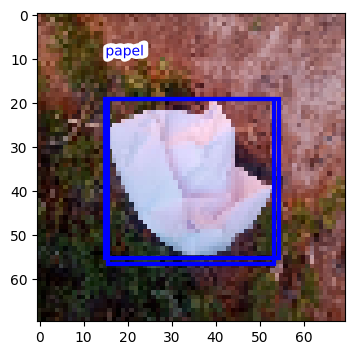

In [ ]:
import matplotlib.pyplot as plt


# Llamar a la función plot_anns para mostrar la imagen
plot_predict(img, (labels, bbs), bg=0)

# Mostrar la figura
plt.show()

In [ ]:
# Usar la función predict definida anteriormente para obtener las cajas delimitadoras, las puntuaciones y las etiquetas predichas por el modelo
bbs, (scores, labels) = predict(model, image_tenseor)
# Filtrar las cajas delimitadoras, las etiquetas y las puntuaciones que corresponden al fondo (clase 0) y quedarse solo con las que corresponden a los objetos (clase > 0)
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]
# Mostrar las cajas delimitadoras, las etiquetas y las puntuaciones filtradas
bbs, labels, scores

(tensor([[0.1071, 0.1071, 0.1786, 0.1786]]), tensor([2]), tensor([0.9985]))

In [ ]:
# Usar la función nms de torchvision.ops para eliminar las cajas delimitadoras que se superponen demasiado entre sí y quedarse con las que tienen mayor puntuación
# El parámetro iou_threshold indica el umbral de solapamiento (IoU) a partir del cual se eliminan las cajas
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)
# Mostrar los índices de las cajas delimitadoras que se han conservado tras aplicar nms
nms_ixs


tensor([0])

<Figure size 400x200 with 0 Axes>

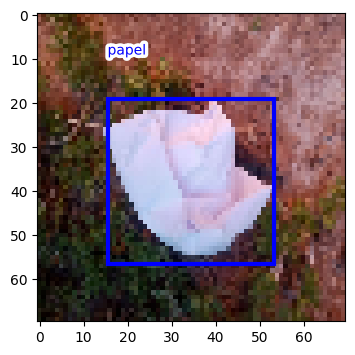

In [ ]:
# Filtrar las cajas delimitadoras y las etiquetas usando los índices obtenidos por nms
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
# Desnormalizar las coordenadas de las cajas delimitadoras usando la función unnorm definida anteriormente y el alto y el ancho de la imagen
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
# Usar la función plot_anns definida anteriormente para visualizar la imagen y las anotaciones filtradas
plot_anns(img, (labels, bbs))
# Mostrar la imagen con matplotlib.pyplot
plt.show()


#Retinanet

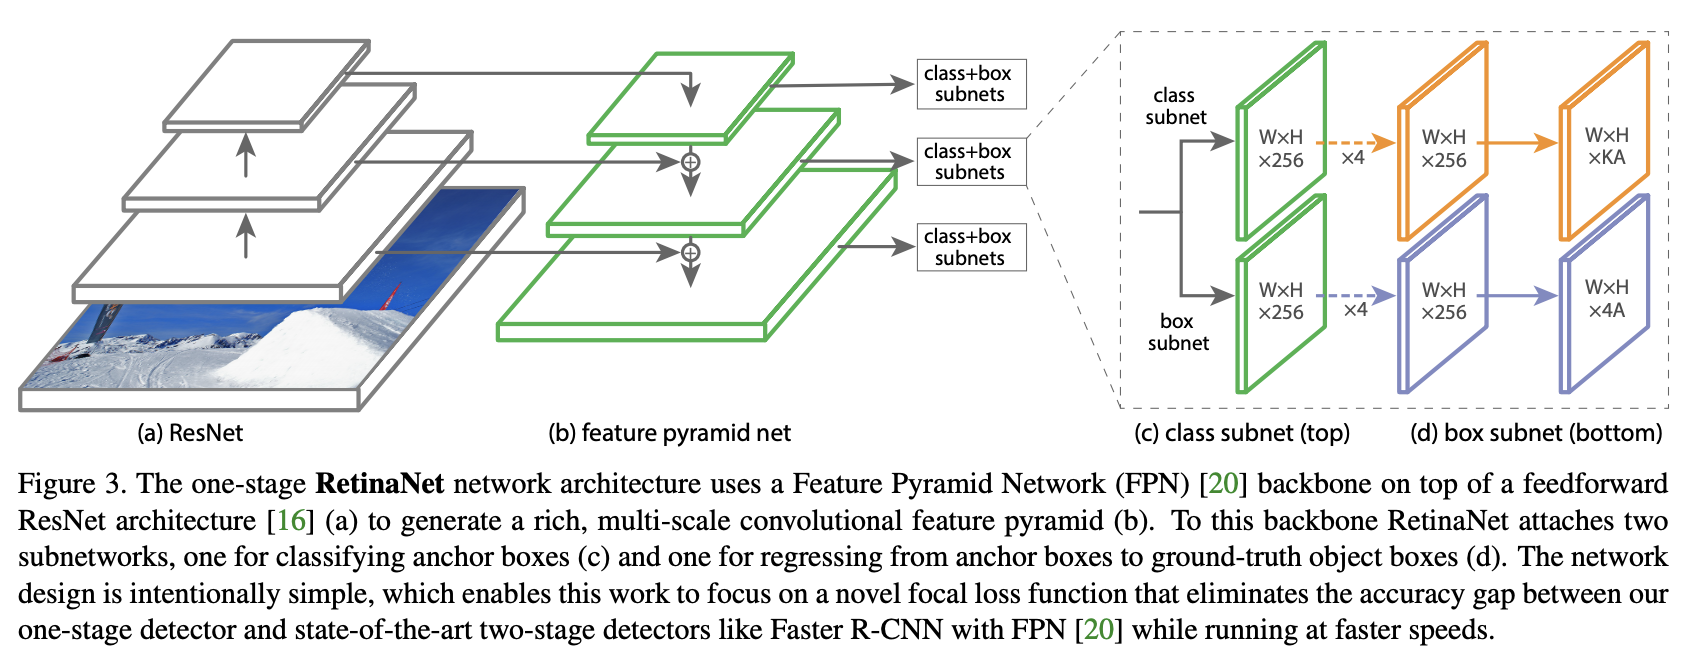

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class RetinaNet2(torch.nn.Module):
    def __init__(self, n_channels=3, n_classes=5, num_anchors=9):
        super(RetinaNet2, self).__init__()
        self.n_classes = n_classes # Guardar el número de clases como atributo
        # Backbone
        self.backbone = models.resnet50(pretrained=True) # Crear una red ResNet-50 preentrenada como backbone
        self.backbone_layers = nn.Sequential(*list(self.backbone.children())[:-2]) # Obtener todas las capas de la red ResNet-50 excepto las dos últimas
        # capa adaptativa de promedio y una capa lineal
        # Additional convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(2048, 256, kernel_size=1), # Crear una capa convolucional adicional que reduce el número de canales de 2048 a 256
            nn.ReLU() # Añadir una activación ReLU
        ) 
        # En la arquitectura de la red ResNet-50, la capa de salida final tiene 2048 canales
        # Feature Pyramid Network (FPN)
        self.fpn = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1), # Crear una capa convolucional que mantiene el número de canales en 256
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Crear una capa convolucional que mantiene el número de canales en 256 y el tamaño espacial con relleno 1
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Crear otra capa convolucional igual a la anterior
            nn.Conv2d(256, 256, kernel_size=3, padding=1) # Crear otra capa convolucional igual a la anterior
        ) # Crear una red FPN como secuencia de cuatro capas convolucionales        
        # Additional convolutional layer
        self.conv2 = nn.Conv2d(256, 256, kernel_size=1) # Crear otra capa convolucional adicional que mantiene el número de canales en 256
        # su propósito es permitir la transformación no lineal de las características y ayudar a extraer características relevantes 
        # Classification and Regression Heads
        self.cls_head = nn.Sequential(
            nn.Conv2d(256, num_anchors * self.n_classes, kernel_size=3, padding=1, groups=1, bias=False), # Crear el cabezal de clasificación como una capa convolucional que tiene num_anchors * n_classes canales de salida, un tamaño de kernel de 3x3 con relleno 1, grupos=n_classes y sin sesgo
            nn.Sigmoid() # Añadir una activación sigmoide para obtener las probabilidades de cada clase para cada ancla
        )

        self.reg_head = nn.Conv2d(256, num_anchors * 4, kernel_size=3, padding=1, groups=1, bias=False) # Crear el cabezal de regresión como una capa convolucional que tiene num_anchors * 4 canales de salida, un tamaño de kernel de 3x3 con relleno 1, grupos=4 y sin sesgo
    def forward(self, x):
        # Backbone
        features = self.backbone_layers(x)
        conv_features1 = self.conv1(features) 
        fpn_features = self.fpn(conv_features1) 
        conv_features2 = self.conv2(fpn_features) 
        cls_scores = self.cls_head(conv_features2) 
        reg_offsets = self.reg_head(conv_features2) 
        batch_size, _, height, width = cls_scores.shape 
        cls_scores = cls_scores.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes)
        reg_offsets = reg_offsets.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
        return cls_scores , reg_offsets

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RetinaNet2()
model = model.to(device)

salida = model(torch.rand((1, 3, 224, 224)).to(device))

In [ ]:
salida[0].shape, salida[1].shape

(torch.Size([1, 441, 5]), torch.Size([1, 441, 4]))

In [ ]:
class FocalLoss(torch.nn.Module):  
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        # inputs: tensor de forma (batch_size, num_anchors, num_classes) con los logits de cada clase para cada ancla
        # targets: tensor de forma (batch_size, num_anchors) con las etiquetas binarias de cada ancla (0 o 1)
        # Calcular la pérdida de entropía cruzada binaria con los logits y las etiquetas
        bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets.unsqueeze(-1), reduction="none")
        # Calcular el factor modulador (1 - p_t)^gamma
        p_t = torch.exp(-bce_loss)
        modulator = (1 - p_t) ** self.gamma
        # Calcular el factor de equilibrio alfa_t
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        # Calcular la pérdida focal como el producto de los tres factores
        focal_loss = alpha_t * modulator * bce_loss
        # Devolver la pérdida focal promediada por el tamaño del lote
        return focal_loss.mean()

In [ ]:
def fit(model, dataloader, num_epochs, num_anchors):
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Define la función de pérdida
    criterion = FocalLoss()

    for epoch in range(1, num_epochs+1):
        model.train()
        train_loss = []
        
        for images, bboxes, labels in dataloader:
            images = images.to(device)
            bboxes = bboxes.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            cls_scores, reg_offsets = outputs
            
            cls_targets = labels.expand(-1, num_anchors).flatten().unsqueeze(0)
            reg_targets = bboxes.expand(-1, num_anchors, -1).reshape(-1, 4)

            
            # Calculate the loss
            cls_loss = criterion(cls_scores, cls_targets)
            reg_loss = criterion(reg_offsets, reg_targets)
            loss = cls_loss + reg_loss
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        print(f"Epoch {epoch}/{num_epochs}, Loss: {np.mean(train_loss)}")


[2]
[(51.800000000000004, 0.0, 180.32000000000002, 224.0)]


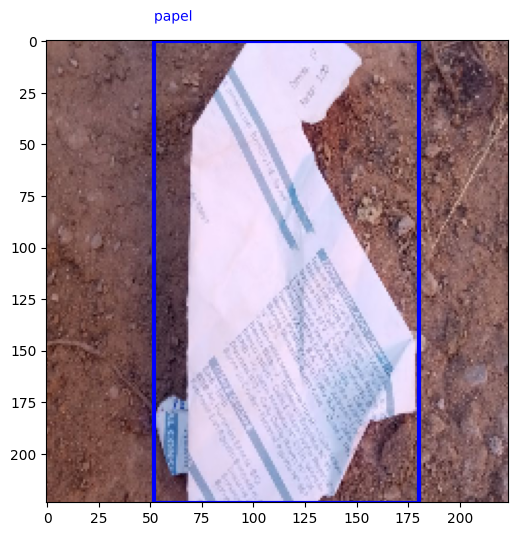

In [ ]:
import albumentations as A

ix = random.randint(0, len(datasetPrueba['train']) - 1)
img_np, anns = get_sample(ix)
labels, bbs = anns

trans = A.Compose([
    A.Resize(224, 224)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

img_np = np.array(img_np)
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

print(labels)
print(bbs)
plot_anns(img, (labels, bbs))
plt.show()

In [ ]:
img.shape

(224, 224, 3)

In [ ]:
img

In [ ]:
annotations = (labels, bbs)
annotations

([2], [(51.52, 40.693333333333335, 166.88, 198.98666666666665)])

In [ ]:
import torch
from torch.utils.data import TensorDataset

# Convierte la imagen y las anotaciones en tensores
img_tensor = torch.tensor(img, dtype=torch.float32)
bbs_tensor = torch.tensor(bbs, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

img_tensor.shape, bbs_tensor.shape, labels_tensor.shape


(torch.Size([224, 224, 3]), torch.Size([1, 4]), torch.Size([1]))

In [ ]:
img_tensor.unsqueeze(0).shape

torch.Size([1, 224, 224, 3])

In [ ]:
img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)
bbs_tensor = torch.tensor(bbs).unsqueeze(0)
labels_tensor = torch.tensor(labels).unsqueeze(0)

dataset = TensorDataset(img_tensor, bbs_tensor, labels_tensor)


In [ ]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
from torch.utils.data import DataLoader

batch_size = 1  # Tamaño del lote

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
# Define el modelo
model = RetinaNet2()

# Define el optimizador
num_epochs = 10  # Número de épocas

num_anchors = 9  # Número de anclas en el modelo RetinaNet
fit(model, dataloader, num_epochs, num_anchors)

ValueError: ignored

#Aneterior

(144, [])

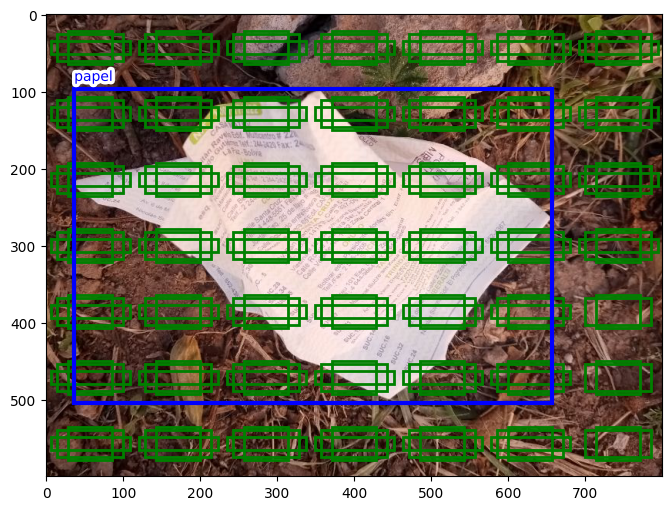

In [ ]:
#scales = [4, 4, 4]
scales = [7, 5, 1]              
centers = [(0.5, 0.5)] 
size_scales = [0.5]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
k, anchors, grid_size = generate_anchors(scales, centers, sizes)

plot_anchors(img_np, anns, anchors)
len(anchors), k
#225

In [ ]:
k=[3,3,3]

# Modelo

In [ ]:
import torch.nn as nn
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def flatten_conv(x, k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

class out_conv(torch.nn.Module):
    def __init__(self, c_in, k, n_classes):
        super().__init__()
        self.k = k
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)
    def forward(self, x):
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

def conv(c_i, c_o, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(c_i, c_o, 3, stride=stride, padding=padding), 
        nn.ReLU(),
        #nn.BatchNorm2d(c_o)
    )

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


class SSDRetinaNet(torch.nn.Module):
    def __init__(self, n_channels=3, n_classes=5, k_ssd=[1, 1, 1], k_retinanet=3):
        super().__init__()

       # Red base (ResNet)
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Capas de detección SSD
        self.conv_reduce_channels_ssd = nn.Conv2d(2048, 32, kernel_size=1) 

        self.conv3_ssd = nn.Sequential(
            nn.Conv2d(32, 256, kernel_size=1),
            nn.LeakyReLU(inplace=True), # Cambiar ReLU por LeakyReLU
            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True), # Cambiar ReLU por LeakyReLU
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True), # Cambiar ReLU por LeakyReLU
        )

        # Capas de detección SSD
        self.out4_ssd_loc = out_conv(64, k_ssd[0], 4)  # Salida de localización SSD
        self.out4_ssd_conf = out_conv(64, k_ssd[0], n_classes)  # Salida de clasificación SSD
        self.out5_ssd_loc = out_conv(64, k_ssd[1], 4)  # Salida de localización SSD
        self.out5_ssd_conf = out_conv(64, k_ssd[1], n_classes)  # Salida de clasificación SSD
        self.out6_ssd_loc = out_conv(64, k_ssd[2], 4)  # Salida de localización SSD
        self.out6_ssd_conf = out_conv(64, k_ssd[2], n_classes)  # Salida de clasificación SSD

        # Capas de detección RetinaNet
        self.conv_reduce_channels_retinanet = nn.Conv2d(1024, 32, kernel_size=1) 
        self.conv_reduce_channels_resnet4 = nn.Conv2d(2048, 32, kernel_size=1) 
        self.conv3_retinanet = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.out_loc_retinanet = nn.Conv2d(256, k_retinanet * 4, kernel_size=3, stride=1, padding=1)  # Salida de localización RetinaNet
        self.out_conf_retinanet = nn.Conv2d(256, k_retinanet * n_classes, kernel_size=3, stride=1, padding=1) 

    def forward(self, x):
        # Red base (ResNet)
        x = self.resnet.conv1(x)
        print(x.shape)
        x = self.resnet.bn1(x)
        print(x.shape)
        x = self.resnet.relu(x)
        print(x.shape)
        x = self.resnet.maxpool(x)
        print(x.shape)
        x = self.resnet.layer1(x)
        print(x.shape)
        x = self.resnet.layer2(x)
        print(x.shape)
        x_ssd = self.resnet.layer3(x) # Guardar la salida de la capa 3 de ResNet
        print(x_ssd.shape)


        # Capas de detección SSD
        x_ssd_reduced = self.conv_reduce_channels_ssd(x_ssd) # Pasar la salida de la capa 3 de ResNet a la capa convolucional que reduce los canales para la detección SSD
        print(x_ssd_reduced.shape)
        x1_ssd = self.conv3_ssd(x_ssd_reduced)
        print(x1_ssd.shape)
        o1l_ssd, o1c_ssd = self.out4_ssd_loc(x1_ssd), self.out4_ssd_conf(x1_ssd)
        o2l_ssd, o2c_ssd = self.out5_ssd_loc(x1_ssd), self.out5_ssd_conf(x1_ssd)
        o3l_ssd, o3c_ssd = self.out6_ssd_loc(x1_ssd), self.out6_ssd_conf(x1_ssd)

        # Capas de detección RetinaNet
        x_retinanet = self.resnet.layer4(x) # Pasar la salida de la capa 3 de ResNet sin reducir los canales a la capa 4 de ResNet
        x_retinanet = self.conv_reduce_channels_resnet4(x_retinanet) # Pasar la salida de la capa 4 de ResNet a la capa convolucional que reduce los canales para la detección RetinaNet
        x_retinanet = self.conv_reduce_channels_retinanet(x_retinanet) # Cambiar x por x_retinanet
        x_retinanet = self.conv3_retinanet(x_retinanet)
        o_loc_retinanet = self.out_loc_retinanet(x_retinanet)
        o_conf_retinanet = self.out_conf_retinanet(x_retinanet)

        # Salidas separadas para la clasificación y la localización
        output = {
            'ssd_loc': torch.cat([o1l_ssd, o2l_ssd, o3l_ssd], dim=1),
            'ssd_conf': torch.cat([o1c_ssd, o2c_ssd, o3c_ssd], dim=1),
            'retinanet_loc': o_loc_retinanet,
            'retinanet_conf': o_conf_retinanet
        }
        return output

In [ ]:
net = SSDRetinaNet(n_channels=len(classes))
input_tensor = torch.rand((1, len(classes), 150, 150))
output_ssd = net.forward(input_tensor)['ssd_conf']
output_retinanet = net.forward(input_tensor)['retinanet_conf']
print(output_ssd.shape)  # Verificar el número de canales en la salida de SSD
print(output_retinanet.shape)  # Verificar el número de canales en la salida de RetinaNet


torch.Size([1, 64, 75, 75])
torch.Size([1, 64, 75, 75])
torch.Size([1, 64, 75, 75])
torch.Size([1, 64, 38, 38])
torch.Size([1, 256, 38, 38])
torch.Size([1, 512, 19, 19])
torch.Size([1, 1024, 10, 10])
torch.Size([1, 32, 10, 10])
torch.Size([1, 64, 3, 3])


RuntimeError: ignored

In [ ]:
retinanet = SSDRetinaNet()
# Realizar una prueba del forward
x = torch.rand((1, 3, 150, 150))
output = retinanet(x)


torch.Size([1, 64, 75, 75])
torch.Size([1, 64, 75, 75])
torch.Size([1, 64, 75, 75])
torch.Size([1, 64, 38, 38])
torch.Size([1, 256, 38, 38])
torch.Size([1, 512, 19, 19])
torch.Size([1, 1024, 10, 10])


RuntimeError: ignored

# MODELO

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class RetinaNet(torch.nn.Module):
    def __init__(self, n_channels=3, n_classes=1, num_anchors=9):
        super(RetinaNet, self).__init__()
        self.n_classes = n_classes # Guardar el número de clases como atributo

        # Backbone
        self.backbone = models.resnet50(pretrained=True) # Crear una red ResNet-50 preentrenada como backbone
        self.backbone_layers = nn.Sequential(*list(self.backbone.children())[:-2]) # Obtener todas las capas de la red ResNet-50 excepto las dos últimas
        # capa adaptativa de promedio y una capa lineal

        # Additional convolutional layer
        self.conv1 = nn.Conv2d(2048, 256, kernel_size=1) # Crear una capa convolucional adicional que reduce el número de canales de 2048 a 256
        # En la arquitectura de la red ResNet-50, la capa de salida final tiene 2048 canales

        # Feature Pyramid Network (FPN)
        self.fpn = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1), # Crear una capa convolucional que mantiene el número de canales en 256
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Crear una capa convolucional que mantiene el número de canales en 256 y el tamaño espacial con relleno 1
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Crear otra capa convolucional igual a la anterior
            nn.Conv2d(256, 256, kernel_size=3, padding=1) # Crear otra capa convolucional igual a la anterior
        ) # Crear una red FPN como secuencia de cuatro capas convolucionales
        
        # Additional convolutional layer
        self.conv2 = nn.Conv2d(256, 256, kernel_size=1) # Crear otra capa convolucional adicional que mantiene el número de canales en 256
        # su propósito es permitir la transformación no lineal de las características y ayudar a extraer características relevantes 

        # Classification and Regression Heads
        self.cls_head = nn.Conv2d(256, num_anchors * self.n_classes, kernel_size=3, padding=1, groups=self.n_classes, bias=False) # Crear el cabezal de clasificación como una capa convolucional que tiene num_anchors * n_classes canales de salida, un tamaño de kernel de 3x3 con relleno 1, grupos=n_classes y sin sesgo
        self.reg_head = nn.Conv2d(256, num_anchors * 4, kernel_size=3, padding=1, groups=4, bias=False) # Crear el cabezal de regresión como una capa convolucional que tiene num_anchors * 4 canales de salida, un tamaño de kernel de 3x3 con relleno 1, grupos=4 y sin sesgo

    def forward(self, x):
        # Backbone
        features = self.backbone_layers(x) # Pasar el tensor de entrada por las capas del backbone y obtener las características
        
        # Additional convolutional layer
        conv_features1 = self.conv1(features) # Pasar las características por la primera capa convolucional adicional y reducir el número de canales a 256

        # Feature Pyramid Network (FPN)
        fpn_features = self.fpn(conv_features1) # Pasar las características por la red FPN y obtener las características piramidales
        
        # Additional convolutional layer
        conv_features2 = self.conv2(fpn_features) # Pasar las características por la segunda capa convolucional adicional y mantener el número de canales en 256

        # Classification and Regression Heads
        cls_scores = self.cls_head(conv_features2) # Pasar las características por el cabezal de clasificación y obtener las puntuaciones para cada ancla y cada clase
        reg_offsets = self.reg_head(conv_features2) # Pasar las características por el cabezal de regresión y obtener los desplazamientos para cada ancla
        
        # Reshape cls_scores and reg_offsets
        batch_size, _, height, width = cls_scores.shape # Obtener el tamaño del lote y las dimensiones espaciales del tensor cls_scores

        cls_scores = cls_scores.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) # Reordenar y remodelar el tensor cls_scores para tener la forma (batch_size, num_anchors * height * width / n_classes , n_classes)
        reg_offsets = reg_offsets.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4) # Reordenar y remodelar el tensor reg_offsets para tener la forma (batch_size , num_anchors * height * width / 4 , 4)
        
        return cls_scores , reg_offsets # Devolver los tensores cls_scores y reg_offsets como salidas del modelo



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class RetinaNet2(torch.nn.Module):
    def __init__(self, n_channels=3, n_classes=5, num_anchors=9):
        super(RetinaNet2, self).__init__()
        self.n_classes = n_classes # Guardar el número de clases como atributo
        # Backbone
        self.backbone = models.resnet50(pretrained=True) # Crear una red ResNet-50 preentrenada como backbone
        self.backbone_layers = nn.Sequential(*list(self.backbone.children())[:-2]) # Obtener todas las capas de la red ResNet-50 excepto las dos últimas
        # capa adaptativa de promedio y una capa lineal
        # Additional convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(2048, 256, kernel_size=1), # Crear una capa convolucional adicional que reduce el número de canales de 2048 a 256
            nn.ReLU() # Añadir una activación ReLU
        ) 
        # En la arquitectura de la red ResNet-50, la capa de salida final tiene 2048 canales
        # Feature Pyramid Network (FPN)
        self.fpn = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1), # Crear una capa convolucional que mantiene el número de canales en 256
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Crear una capa convolucional que mantiene el número de canales en 256 y el tamaño espacial con relleno 1
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Crear otra capa convolucional igual a la anterior
            nn.Conv2d(256, 256, kernel_size=3, padding=1) # Crear otra capa convolucional igual a la anterior
        ) # Crear una red FPN como secuencia de cuatro capas convolucionales        
        # Additional convolutional layer
        self.conv2 = nn.Conv2d(256, 256, kernel_size=1) # Crear otra capa convolucional adicional que mantiene el número de canales en 256
        # su propósito es permitir la transformación no lineal de las características y ayudar a extraer características relevantes 
        # Classification and Regression Heads
        self.cls_head = nn.Sequential(
            nn.Conv2d(256, num_anchors * self.n_classes, kernel_size=3, padding=1, groups=1, bias=False), # Crear el cabezal de clasificación como una capa convolucional que tiene num_anchors * n_classes canales de salida, un tamaño de kernel de 3x3 con relleno 1, grupos=n_classes y sin sesgo
            nn.Sigmoid() # Añadir una activación sigmoide para obtener las probabilidades de cada clase para cada ancla
        )

        self.reg_head = nn.Conv2d(256, num_anchors * 4, kernel_size=3, padding=1, groups=1, bias=False) # Crear el cabezal de regresión como una capa convolucional que tiene num_anchors * 4 canales de salida, un tamaño de kernel de 3x3 con relleno 1, grupos=4 y sin sesgo
    def forward(self, x):
        # Backbone
        features = self.backbone_layers(x)
        conv_features1 = self.conv1(features) 
        fpn_features = self.fpn(conv_features1) 
        conv_features2 = self.conv2(fpn_features) 
        cls_scores = self.cls_head(conv_features2) 
        reg_offsets = self.reg_head(conv_features2) 
        batch_size, _, height, width = cls_scores.shape 
        cls_scores = cls_scores.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes)
        reg_offsets = reg_offsets.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
        return cls_scores , reg_offsets


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RetinaNet2()
model = model.to(device)

salida = model(torch.rand((1, 3, 100, 100)).to(device))


In [ ]:
salida[0].shape, salida[1].shape

(torch.Size([1, 144, 5]), torch.Size([1, 144, 4]))

# prueba

In [ ]:
loss_fn = FocalLoss() # Pérdida de clasificación
reg_loss_fn = torch.nn.SmoothL1Loss()  # Pérdida de regresión
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # optimizador


In [ ]:
num_epochs = 10

# Iterar sobre las épocas
for epoch in range(num_epochs):
    # Inicializar las variables para almacenar las pérdidas totales de clasificación y regresión
    total_cls_loss = 0
    total_reg_loss = 0
    # Iterar sobre el generador de datos de entrenamiento
    for batch_data in train_dataloader:
        # Obtener las imágenes y las anotaciones del lote
        images = torch.stack([data[0] for data in batch_data])
        annotations = torch.stack([data[1] for data in batch_data])
        # Mover las imágenes y las anotaciones al dispositivo (CPU o GPU)
        images = images.to(device)
        annotations = annotations.to(device)
        # Calcular las salidas del modelo para el lote
        cls_scores, reg_offsets = model(images)
        # Calcular la pérdida de clasificación y la pérdida de regresión para el lote
        cls_loss = loss_fn(cls_scores, annotations[:, :, 4])
        reg_loss = reg_loss_fn(reg_offsets, annotations[:, :, :4])
        # Calcular la pérdida total como la suma de las dos pérdidas
        total_loss = cls_loss + reg_loss
        # Actualizar las pérdidas totales de clasificación y regresión
        total_cls_loss += cls_loss.item()
        total_reg_loss += reg_loss.item()
        # Poner a cero los gradientes del optimizador
        optimizer.zero_grad()
        # Calcular los gradientes de la pérdida total con respecto a los parámetros del modelo
        total_loss.backward()
        # Actualizar los parámetros del modelo usando el optimizador
        optimizer.step()
    # Calcular las pérdidas promedio de clasificación y regresión por época
    avg_cls_loss = total_cls_loss / len(train_dataloader)
    avg_reg_loss = total_reg_loss / len(train_dataloader)
    # Imprimir las pérdidas promedio por época
    print(f"Epoch {epoch + 1}: Classification Loss = {avg_cls_loss}, Regression Loss = {avg_reg_loss}")


TypeError: ignored